In [1]:
%reload_ext autoreload
%autoreload 2

# env: /weka/<PATH>/github/model-selection/envs/benj/bin/python - 3.10.4
# original notebook: ../tmp/model-selection/notebooks/check_different_criteria.ipynb

import os
import torch
import json
import sys
import numpy as np
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids # pip install scikit-learn-extra
import datetime
import importlib
import random
from typing import Any, Dict, Optional

from sklearn.model_selection import KFold
from matplotlib import pyplot as plt

# local modules
# sys.path.insert(
#     0,
#     os.path.join(
#         os.path.dirname(os.path.abspath('')), "src"
#     )
# )

import figure_generation_helpers.helpers
importlib.reload(figure_generation_helpers.helpers)

from figure_generation_helpers.helpers import NNModel, baseline_mae, baseline_empirical_rank_score, SimpleNN, MLPRegressor, HemmingNNModel, calculate_model_distance_matrix_for_confidences_tensor, get_average_absolute_error_with_model_class, get_distance_matrix_list_with_bootstrapping, create_model_of_class, plot_average_model_performance_over_sample_size

from utility.utils import (
    read_old_checkpoint,
    get_device
)

# sys.path.pop(0)

2025-05-15 09:36:04.325795: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-15 09:36:04.472025: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-15 09:36:05.747442: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/nvidia/hpc_sdk/Linux_x86_64/2023/cuda/12.2/lib64:/opt/nvidia/hpc_sdk/L

ModuleNotFoundError: No module named 'utility'

In [ ]:
!which python

In [8]:
!pip install -q scikit-learn-extra umap-learn

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
stable-diffusion-sdkit 2.1.4 requires open-clip-torch==2.0.2, but you have open-clip-torch 2.24.0 which is incompatible.
stable-diffusion-sdkit 2.1.4 requires transformers==4.26.1, but you have transformers 4.44.0 which is incompatible.


In [4]:
path_to_save_folder = "/mnt/lustre/work/oh/owl813/repos/model-selection/checkpoints"

timm_model_confidence_for_val_samples_tensor = torch.load(f=os.path.join(path_to_save_folder, "timm_model_confidences_for_val_samples.tensor"))


/tmp/ipykernel_968094/796740258.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  timm_model_confidence_for_val_samples_tensor = torch.load(f=os.path.join(path_to_save_fol

In [5]:
path_to_save_folder = "/mnt/lustre/work/oh/owl813/repos/model-selection/checkpoints"

open_clip_model_confidence_for_val_samples_tensor = torch.load(f=os.path.join(path_to_save_folder, "open_clip_model_confidences_cifar_100.tensor"))

/tmp/ipykernel_968094/1071778926.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  open_clip_model_confidence_for_val_samples_tensor = torch.load(f=os.path.join(path_to_sa

In [8]:
with open(os.path.join(path_to_save_folder, "timm_model_catalog_with_per_class.json"), mode="r") as fp:
    timm_model_catalog = json.load(fp=fp)

In [9]:
with open(os.path.join(path_to_save_folder, "open_clip_model_catalog_with_per_class.json"), mode="r") as fp:
    open_clip_model_catalog = json.load(fp=fp)

In [10]:
def apply_along_axis(function, x, axis: int = 0):
    return torch.stack([
        function(x_i) for x_i in torch.unbind(x, dim=axis)
    ], dim=axis)

In [11]:
def tensor_entropy(x):
    counts = torch.bincount(x)
    counts = counts[counts!=0]
    frequencies = counts / counts.sum()
    return - (frequencies*frequencies.log()).sum()

In [12]:
def get_categorical_entropy_per_sample(tensor: torch.tensor):
    predicted_class_tensor = torch.argmax(tensor, dim=2)

    per_sample_entropy = apply_along_axis(tensor_entropy,
                                          x=predicted_class_tensor,
                                          axis=0)
    return per_sample_entropy

In [21]:
{key+'//'+open_clip_model_catalog[key]['open_clip_model']['model_name']+'+'+open_clip_model_catalog[key]['open_clip_model']['pretrained']: datetime.datetime(year=2022, month=12, day=2) for key in open_clip_model_catalog.keys()}.__repr__()

"{'/mnt/lustre/work/oh/owl813/repos/model-selection/checkpoints/open_clip_models_for_ensemble_1_imagenet.pkl_model_0//ViT-H-14-378-quickgelu+dfn5b': datetime.datetime(2022, 12, 2, 0, 0), '/mnt/lustre/work/oh/owl813/repos/model-selection/checkpoints/open_clip_models_for_ensemble_1_imagenet.pkl_model_1//ViT-H-14-quickgelu+dfn5b': datetime.datetime(2022, 12, 2, 0, 0), '/mnt/lustre/work/oh/owl813/repos/model-selection/checkpoints/open_clip_models_for_ensemble_1_imagenet.pkl_model_2//ViT-SO400M-14-SigLIP-384+webli': datetime.datetime(2022, 12, 2, 0, 0), '/mnt/lustre/work/oh/owl813/repos/model-selection/checkpoints/open_clip_models_for_ensemble_2_imagenet.pkl_model_0//ViT-SO400M-14-SigLIP+webli': datetime.datetime(2022, 12, 2, 0, 0), '/mnt/lustre/work/oh/owl813/repos/model-selection/checkpoints/open_clip_models_for_ensemble_2_imagenet.pkl_model_1//ViT-L-14-quickgelu+dfn2b': datetime.datetime(2022, 12, 2, 0, 0), '/mnt/lustre/work/oh/owl813/repos/model-selection/checkpoints/open_clip_models_fo

# select models

In [13]:
timm_model_date_mapping = {'maxvit_large_tf_224.in1k': datetime.datetime(2022, 12, 2, 0, 0),
 'rexnet_100.nav_in1k': datetime.datetime(2023, 3, 20, 0, 0),
 'inception_next_base.sail_in1k_384': datetime.datetime(2023, 8, 24, 0, 0),
 'resnext101_32x4d.fb_ssl_yfcc100m_ft_in1k': datetime.datetime(2023, 4, 5, 0, 0),
 'vit_base_patch32_224.augreg_in21k_ft_in1k': datetime.datetime(2022, 12, 22, 0, 0),
 'tf_mobilenetv3_large_100.in1k': datetime.datetime(2022, 12, 16, 0, 0),
 'tf_efficientnet_es.in1k': datetime.datetime(2022, 12, 13, 0, 0),
 'convnextv2_nano.fcmae_ft_in22k_in1k_384': datetime.datetime(2023, 1, 5, 0, 0),
 'vit_base_patch16_224.augreg_in21k_ft_in1k': datetime.datetime(2022, 12, 22, 0, 0),
 'mobilevitv2_075.cvnets_in1k': datetime.datetime(2023, 4, 25, 0, 0),
 'volo_d4_448.sail_in1k': datetime.datetime(2023, 4, 13, 0, 0),
 'lambda_resnet26t.c1_in1k': datetime.datetime(2023, 4, 16, 0, 0),
 'xcit_large_24_p8_224.fb_in1k': datetime.datetime(2023, 4, 13, 0, 0),
 'repghostnet_111.in1k': datetime.datetime(2023, 8, 20, 0, 0),
 'mobilevitv2_200.cvnets_in22k_ft_in1k_384': datetime.datetime(2023, 4, 25, 0, 0),
 'coat_lite_small.in1k': datetime.datetime(2023, 4, 24, 0, 0),
 'coatnext_nano_rw_224.sw_in1k': datetime.datetime(2023, 1, 20, 0, 0),
 'hiera_large_224.mae_in1k_ft_in1k': datetime.datetime(2024, 5, 13, 0, 0),
 'repvit_m2_3.dist_450e_in1k': datetime.datetime(2023, 10, 20, 0, 0),
 'tiny_vit_5m_224.dist_in22k_ft_in1k': datetime.datetime(2023, 9, 1, 0, 0),
 'convformer_m36.sail_in1k_384': datetime.datetime(2022, 12, 2, 0, 0),
 'deit3_base_patch16_384.fb_in22k_ft_in1k': datetime.datetime(2023, 5, 5, 0, 0),
 'xcit_large_24_p16_224.fb_in1k': datetime.datetime(2023, 4, 13, 0, 0),
 'tf_efficientnet_b2.in1k': datetime.datetime(2023, 4, 27, 0, 0),
 'swinv2_large_window12to24_192to384.ms_in22k_ft_in1k': datetime.datetime(2023, 3, 18, 0, 0),
 'vit_large_patch14_clip_336.laion2b_ft_in1k': datetime.datetime(2022, 11, 7, 0, 0),
 'fastvit_sa24.apple_in1k': datetime.datetime(2023, 8, 23, 0, 0),
 'rexnet_150.nav_in1k': datetime.datetime(2023, 3, 20, 0, 0),
 'maxxvit_rmlp_small_rw_256.sw_in1k': datetime.datetime(2023, 1, 20, 0, 0),
 'beitv2_base_patch16_224.in1k_ft_in22k_in1k': datetime.datetime(2022, 12, 23, 0, 0),
 'resnet50.gluon_in1k': datetime.datetime(2023, 4, 5, 0, 0),
 'poolformer_m36.sail_in1k': datetime.datetime(2023, 5, 5, 0, 0),
 'vit_base_patch16_224.augreg2_in21k_ft_in1k': datetime.datetime(2022, 12, 22, 0, 0),
 'xcit_small_12_p16_224.fb_dist_in1k': datetime.datetime(2023, 4, 13, 0, 0),
 'ghostnetv2_160.in1k': datetime.datetime(2023, 8, 20, 0, 0),
 'caformer_b36.sail_in22k_ft_in1k_384': datetime.datetime(2023, 5, 5, 0, 0),
 'cait_xxs36_224.fb_dist_in1k': datetime.datetime(2023, 4, 13, 0, 0),
 'flexivit_small.1200ep_in1k': datetime.datetime(2022, 12, 22, 0, 0),
 'tf_efficientnet_b7.ns_jft_in1k': datetime.datetime(2022, 12, 13, 0, 0),
 'swin_small_patch4_window7_224.ms_in22k_ft_in1k': datetime.datetime(2023, 3, 18, 0, 0),
 'beit_base_patch16_384.in22k_ft_in22k_in1k': datetime.datetime(2022, 12, 23, 0, 0),
 'tf_mixnet_l.in1k': datetime.datetime(2022, 12, 13, 0, 0),
 'vit_small_patch16_224.augreg_in1k': datetime.datetime(2022, 12, 22, 0, 0),
 'beitv2_base_patch16_224.in1k_ft_in1k': datetime.datetime(2023, 3, 9, 0, 0),
 'efficientvit_b1.r256_in1k': datetime.datetime(2023, 8, 19, 0, 0),
 'swinv2_base_window16_256.ms_in1k': datetime.datetime(2023, 3, 18, 0, 0),
 'efficientnet_b3_pruned.in1k': datetime.datetime(2022, 12, 13, 0, 0),
 'poolformerv2_m48.sail_in1k': datetime.datetime(2023, 5, 3, 0, 0),
 'xcit_tiny_24_p16_384.fb_dist_in1k': datetime.datetime(2023, 4, 13, 0, 0),
 'vit_wee_patch16_reg1_gap_256.sbb_in1k': datetime.datetime(2024, 5, 13, 0, 0),
 'haloregnetz_b.ra3_in1k': datetime.datetime(2023, 4, 26, 0, 0),
 'vit_base_patch32_clip_224.openai_ft_in1k': datetime.datetime(2022, 11, 10, 0, 0),
 'deit3_small_patch16_384.fb_in22k_ft_in1k': datetime.datetime(2023, 3, 28, 0, 0),
 'tf_efficientnet_b1.in1k': datetime.datetime(2023, 4, 27, 0, 0),
 'vit_betwixt_patch16_reg1_gap_256.sbb_in1k': datetime.datetime(2024, 5, 11, 0, 0),
 'ghostnetv2_130.in1k': datetime.datetime(2023, 8, 20, 0, 0),
 'regnety_064.pycls_in1k': datetime.datetime(2023, 3, 21, 0, 0),
 'convnext_base.clip_laion2b_augreg_ft_in12k_in1k': datetime.datetime(2023, 3, 31, 0, 0),
 'gmixer_24_224.ra3_in1k': datetime.datetime(2023, 3, 28, 0, 0),
 'repvit_m2.dist_in1k': datetime.datetime(2023, 8, 25, 0, 0),
 'resnext50_32x4d.tv_in1k': datetime.datetime(2023, 4, 5, 0, 0),
 'mobilevitv2_125.cvnets_in1k': datetime.datetime(2023, 4, 25, 0, 0),
 'resnetv2_101x3_bit.goog_in21k_ft_in1k': datetime.datetime(2023, 3, 22, 0, 0),
 'repvit_m1.dist_in1k': datetime.datetime(2023, 8, 25, 0, 0),
 'efficientvit_l1.r224_in1k': datetime.datetime(2023, 11, 21, 0, 0),
 'dla102.in1k': datetime.datetime(2023, 4, 24, 0, 0),
 'convnext_base.clip_laion2b_augreg_ft_in12k_in1k_384': datetime.datetime(2023, 3, 31, 0, 0),
 'vit_base_patch16_clip_224.laion2b_ft_in12k_in1k': datetime.datetime(2022, 11, 28, 0, 0),
 'convformer_s36.sail_in1k_384': datetime.datetime(2023, 5, 5, 0, 0),
 'selecsls60.in1k': datetime.datetime(2023, 4, 25, 0, 0),
 'xcit_small_24_p8_224.fb_dist_in1k': datetime.datetime(2023, 4, 13, 0, 0),
 'hrnet_w18_small_v2.ms_in1k': datetime.datetime(2023, 4, 24, 0, 0),
 'convnext_xlarge.fb_in22k_ft_in1k_384': datetime.datetime(2022, 12, 13, 0, 0),
 'vit_large_patch14_clip_224.openai_ft_in1k': datetime.datetime(2022, 11, 2, 0, 0),
 'gcvit_xxtiny.in1k': datetime.datetime(2022, 12, 27, 0, 0),
 'crossvit_9_dagger_240.in1k': datetime.datetime(2023, 4, 24, 0, 0),
 'efficientformer_l7.snap_dist_in1k': datetime.datetime(2023, 2, 3, 0, 0),
 'tf_efficientnet_b0.aa_in1k': datetime.datetime(2022, 12, 13, 0, 0),
 'regnety_320.swag_lc_in1k': datetime.datetime(2023, 3, 21, 0, 0),
 'tf_efficientnet_cc_b1_8e.in1k': datetime.datetime(2022, 12, 13, 0, 0),
 'xception71.tf_in1k': datetime.datetime(2023, 4, 22, 0, 0),
 'maxvit_base_tf_512.in1k': datetime.datetime(2022, 12, 2, 0, 0),
 'volo_d3_448.sail_in1k': datetime.datetime(2023, 4, 13, 0, 0),
 'regnety_160.swag_lc_in1k': datetime.datetime(2023, 3, 21, 0, 0),
 'resnet152s.gluon_in1k': datetime.datetime(2023, 4, 5, 0, 0),
 'resnest101e.in1k': datetime.datetime(2023, 4, 24, 0, 0),
 'efficientvit_b3.r288_in1k': datetime.datetime(2023, 8, 19, 0, 0),
 'vit_small_patch16_224.augreg_in21k_ft_in1k': datetime.datetime(2022, 12, 22, 0, 0),
 'coat_small.in1k': datetime.datetime(2023, 4, 24, 0, 0),
 'pvtv2_b3.in1k': datetime.datetime(2023, 4, 25, 0, 0),
 'repvit_m1_0.dist_450e_in1k': datetime.datetime(2023, 10, 20, 0, 0),
 'fastvit_sa24.apple_dist_in1k': datetime.datetime(2023, 8, 23, 0, 0),
 'resnet152d.gluon_in1k': datetime.datetime(2023, 4, 5, 0, 0),
 'poolformer_s36.sail_in1k': datetime.datetime(2023, 5, 5, 0, 0),
 'mobileone_s1.apple_in1k': datetime.datetime(2023, 8, 23, 0, 0),
 'cait_xs24_384.fb_dist_in1k': datetime.datetime(2023, 4, 13, 0, 0),
 'eca_halonext26ts.c1_in1k': datetime.datetime(2023, 4, 26, 0, 0),
 'fastvit_ma36.apple_dist_in1k': datetime.datetime(2023, 8, 23, 0, 0),
 'vit_small_patch16_384.augreg_in1k': datetime.datetime(2022, 12, 22, 0, 0),
 'vit_base_patch16_clip_384.openai_ft_in12k_in1k': datetime.datetime(2022, 12, 1, 0, 0),
 'skresnet34.ra_in1k': datetime.datetime(2023, 4, 24, 0, 0),
 'regnety_080_tv.tv2_in1k': datetime.datetime(2023, 3, 21, 0, 0),
 'regnetx_080.pycls_in1k': datetime.datetime(2023, 3, 21, 0, 0),
 'vit_base_patch16_224.orig_in21k_ft_in1k': datetime.datetime(2022, 12, 22, 0, 0),
 'vit_mediumd_patch16_reg4_gap_256.sbb_in12k_ft_in1k': datetime.datetime(2024, 5, 11, 0, 0),
 'convit_base.fb_in1k': datetime.datetime(2023, 4, 24, 0, 0),
 'maxvit_large_tf_512.in1k': datetime.datetime(2022, 12, 2, 0, 0),
 'coat_mini.in1k': datetime.datetime(2023, 4, 24, 0, 0),
 'vit_relpos_small_patch16_224.sw_in1k': datetime.datetime(2022, 12, 23, 0, 0),
 'mobilenetv3_large_100.ra_in1k': datetime.datetime(2022, 12, 16, 0, 0),
 'coatnet_rmlp_2_rw_224.sw_in1k': datetime.datetime(2023, 1, 20, 0, 0),
 'xcit_tiny_24_p8_224.fb_dist_in1k': datetime.datetime(2023, 4, 13, 0, 0),
 'regnetx_008.tv2_in1k': datetime.datetime(2023, 3, 21, 0, 0),
 'densenet201.tv_in1k': datetime.datetime(2023, 4, 22, 0, 0),
 'caformer_b36.sail_in1k_384': datetime.datetime(2023, 5, 5, 0, 0),
 'beitv2_large_patch16_224.in1k_ft_in22k_in1k': datetime.datetime(2022, 12, 23, 0, 0),
 'davit_tiny.msft_in1k': datetime.datetime(2023, 1, 27, 0, 0),
 'xcit_large_24_p8_384.fb_dist_in1k': datetime.datetime(2023, 4, 13, 0, 0),
 'resmlp_24_224.fb_distilled_in1k': datetime.datetime(2023, 3, 28, 0, 0),
 'mobilevitv2_150.cvnets_in22k_ft_in1k': datetime.datetime(2023, 4, 25, 0, 0),
 'deit3_medium_patch16_224.fb_in22k_ft_in1k': datetime.datetime(2023, 3, 28, 0, 0),
 'vit_tiny_patch16_224.augreg_in21k_ft_in1k': datetime.datetime(2022, 12, 22, 0, 0),
 'inception_v3.tv_in1k': datetime.datetime(2023, 4, 25, 0, 0),
 'xcit_small_12_p16_224.fb_in1k': datetime.datetime(2023, 4, 13, 0, 0),
 'volo_d4_224.sail_in1k': datetime.datetime(2023, 4, 13, 0, 0),
 'regnety_008_tv.tv2_in1k': datetime.datetime(2023, 3, 21, 0, 0),
 'swin_tiny_patch4_window7_224.ms_in22k_ft_in1k': datetime.datetime(2023, 3, 18, 0, 0),
 'convnext_large_mlp.clip_laion2b_augreg_ft_in1k_384': datetime.datetime(2023, 2, 7, 0, 0),
 'resnext101_32x16d.fb_swsl_ig1b_ft_in1k': datetime.datetime(2023, 4, 5, 0, 0),
 'convmixer_1024_20_ks9_p14.in1k': datetime.datetime(2023, 4, 24, 0, 0),
 'repvgg_b1g4.rvgg_in1k': datetime.datetime(2023, 3, 22, 0, 0),
 'res2net50_26w_6s.in1k': datetime.datetime(2024, 3, 10, 0, 0),
 'tf_efficientnet_b6.ns_jft_in1k': datetime.datetime(2022, 12, 13, 0, 0),
 'efficientnet_lite0.ra_in1k': datetime.datetime(2022, 12, 13, 0, 0),
 'mobilevitv2_200.cvnets_in22k_ft_in1k': datetime.datetime(2023, 4, 25, 0, 0),
 'mobilenetv2_120d.ra_in1k': datetime.datetime(2022, 12, 13, 0, 0),
 'bat_resnext26ts.ch_in1k': datetime.datetime(2023, 3, 22, 0, 0),
 'cait_s24_224.fb_dist_in1k': datetime.datetime(2023, 4, 13, 0, 0),
 'lambda_resnet26rpt_256.c1_in1k': datetime.datetime(2023, 4, 26, 0, 0),
 'coatnet_bn_0_rw_224.sw_in1k': datetime.datetime(2023, 1, 20, 0, 0),
 'nextvit_small.bd_ssld_6m_in1k': datetime.datetime(2024, 2, 11, 0, 0),
 'convformer_s18.sail_in1k': datetime.datetime(2023, 5, 5, 0, 0),
 'tiny_vit_21m_224.in1k': datetime.datetime(2023, 9, 11, 0, 0),
 'eva_large_patch14_196.in22k_ft_in22k_in1k': datetime.datetime(2022, 12, 22, 0, 0),
 'mobileone_s3.apple_in1k': datetime.datetime(2023, 8, 23, 0, 0),
 'caformer_m36.sail_in1k_384': datetime.datetime(2023, 5, 5, 0, 0),
 'deit_base_distilled_patch16_224.fb_in1k': datetime.datetime(2023, 3, 28, 0, 0),
 'resnext101_32x8d.fb_swsl_ig1b_ft_in1k': datetime.datetime(2023, 4, 5, 0, 0),
 'nest_base_jx.goog_in1k': datetime.datetime(2023, 4, 24, 0, 0),
 'inception_next_base.sail_in1k': datetime.datetime(2023, 4, 24, 0, 0),
 'eva02_large_patch14_448.mim_in22k_ft_in1k': datetime.datetime(2023, 3, 31, 0, 0),
 'tf_efficientnet_b1.ap_in1k': datetime.datetime(2022, 12, 13, 0, 0),
 'cspdarknet53.ra_in1k': datetime.datetime(2023, 4, 12, 0, 0),
 'repghostnet_200.in1k': datetime.datetime(2023, 8, 20, 0, 0),
 'efficientvit_b2.r288_in1k': datetime.datetime(2023, 8, 19, 0, 0),
 'seresnext101_32x4d.gluon_in1k': datetime.datetime(2023, 4, 5, 0, 0),
 'tf_efficientnet_b0.ap_in1k': datetime.datetime(2022, 12, 13, 0, 0),
 'sehalonet33ts.ra2_in1k': datetime.datetime(2023, 4, 26, 0, 0),
 'regnety_320.tv2_in1k': datetime.datetime(2023, 3, 21, 0, 0),
 'nest_small_jx.goog_in1k': datetime.datetime(2023, 4, 24, 0, 0),
 'halo2botnet50ts_256.a1h_in1k': datetime.datetime(2023, 4, 26, 0, 0),
 'coatnet_rmlp_1_rw_224.sw_in1k': datetime.datetime(2023, 1, 20, 0, 0),
 'pvt_v2_b5.in1k': datetime.datetime(2023, 4, 25, 0, 0),
 'crossvit_18_dagger_240.in1k': datetime.datetime(2023, 4, 24, 0, 0),
 'convnext_base.clip_laiona_augreg_ft_in1k_384': datetime.datetime(2023, 2, 3, 0, 0),
 'xcit_medium_24_p16_384.fb_dist_in1k': datetime.datetime(2023, 4, 13, 0, 0),
 'deit_base_patch16_384.fb_in1k': datetime.datetime(2023, 3, 28, 0, 0),
 'resnext101_32x4d.gluon_in1k': datetime.datetime(2023, 4, 5, 0, 0),
 'levit_conv_256.fb_dist_in1k': datetime.datetime(2023, 2, 3, 0, 0),
 'swin_small_patch4_window7_224.ms_in1k': datetime.datetime(2023, 3, 18, 0, 0),
 'maxvit_tiny_rw_224.sw_in1k': datetime.datetime(2023, 1, 20, 0, 0),
 'hardcorenas_a.miil_green_in1k': datetime.datetime(2023, 4, 21, 0, 0),
 'regnety_160.tv2_in1k': datetime.datetime(2023, 3, 21, 0, 0),
 'resnext101_64x4d.tv_in1k': datetime.datetime(2023, 4, 5, 0, 0),
 'convit_small.fb_in1k': datetime.datetime(2023, 4, 24, 0, 0),
 'deit3_large_patch16_224.fb_in22k_ft_in1k': datetime.datetime(2023, 3, 28, 0, 0),
 'vit_base_patch16_rpn_224.sw_in1k': datetime.datetime(2022, 12, 22, 0, 0),
 'resnet101c.gluon_in1k': datetime.datetime(2023, 4, 5, 0, 0),
 'repghostnet_150.in1k': datetime.datetime(2023, 8, 20, 0, 0),
 'resnext50_32x4d.fb_ssl_yfcc100m_ft_in1k': datetime.datetime(2023, 4, 5, 0, 0),
 'res2net101_26w_4s.in1k': datetime.datetime(2023, 4, 24, 0, 0),
 'deit_small_patch16_224.fb_in1k': datetime.datetime(2023, 3, 28, 0, 0),
 'vit_base_patch16_224.sam_in1k': datetime.datetime(2022, 12, 22, 0, 0),
 'efficientvit_b2.r256_in1k': datetime.datetime(2023, 8, 19, 0, 0),
 'convformer_m36.sail_in22k_ft_in1k_384': datetime.datetime(2023, 5, 5, 0, 0),
 'tf_efficientnet_b2.aa_in1k': datetime.datetime(2022, 12, 13, 0, 0),
 'dla60x.in1k': datetime.datetime(2023, 4, 24, 0, 0),
 'tf_efficientnet_b5.aa_in1k': datetime.datetime(2023, 4, 27, 0, 0),
 'gmlp_s16_224.ra3_in1k': datetime.datetime(2023, 3, 28, 0, 0),
 'tresnet_xl.miil_in1k': datetime.datetime(2023, 4, 21, 0, 0),
 'poolformerv2_s24.sail_in1k': datetime.datetime(2023, 5, 5, 0, 0),
 'pit_s_224.in1k': datetime.datetime(2023, 4, 26, 0, 0),
 'resmlp_big_24_224.fb_distilled_in1k': datetime.datetime(2023, 3, 28, 0, 0),
 'xcit_small_12_p16_384.fb_dist_in1k': datetime.datetime(2023, 4, 13, 0, 0),
 'caformer_s18.sail_in1k': datetime.datetime(2023, 5, 5, 0, 0),
 'maxvit_base_tf_384.in1k': datetime.datetime(2022, 12, 2, 0, 0),
 'vit_base_patch16_384.orig_in21k_ft_in1k': datetime.datetime(2022, 12, 22, 0, 0),
 'xcit_medium_24_p8_224.fb_dist_in1k': datetime.datetime(2023, 4, 13, 0, 0),
 'efficientnet_em.ra2_in1k': datetime.datetime(2022, 12, 13, 0, 0),
 'mixnet_m.ft_in1k': datetime.datetime(2022, 12, 13, 0, 0),
 'legacy_seresnet50.in1k': datetime.datetime(2023, 4, 5, 0, 0),
 'tf_efficientnet_b8.ra_in1k': datetime.datetime(2022, 12, 13, 0, 0),
 'vit_base_patch16_clip_384.laion2b_ft_in1k': datetime.datetime(2022, 11, 9, 0, 0),
 'deit3_base_patch16_224.fb_in1k': datetime.datetime(2023, 3, 28, 0, 0),
 'convnext_small.fb_in22k_ft_in1k_384': datetime.datetime(2022, 12, 13, 0, 0),
 'coatnet_rmlp_2_rw_384.sw_in12k_ft_in1k': datetime.datetime(2023, 1, 20, 0, 0),
 'caformer_m36.sail_in22k_ft_in1k': datetime.datetime(2023, 5, 5, 0, 0),
 'gcvit_small.in1k': datetime.datetime(2024, 3, 10, 0, 0),
 'deit3_small_patch16_224.fb_in22k_ft_in1k': datetime.datetime(2023, 3, 28, 0, 0),
 'nextvit_base.bd_in1k': datetime.datetime(2024, 2, 11, 0, 0),
 'xcit_nano_12_p8_384.fb_dist_in1k': datetime.datetime(2023, 4, 13, 0, 0),
 'flexivit_large.1200ep_in1k': datetime.datetime(2022, 12, 22, 0, 0),
 'tiny_vit_21m_512.dist_in22k_ft_in1k': datetime.datetime(2023, 11, 1, 0, 0),
 'caformer_m36.sail_in1k': datetime.datetime(2023, 5, 5, 0, 0),
 'beit_base_patch16_224.in22k_ft_in22k_in1k': datetime.datetime(2022, 12, 23, 0, 0),
 'vit_large_patch14_clip_224.laion2b_ft_in12k_in1k': datetime.datetime(2022, 11, 2, 0, 0),
 'tf_efficientnet_b2.ns_jft_in1k': datetime.datetime(2022, 12, 13, 0, 0),
 'tf_efficientnet_b7.ra_in1k': datetime.datetime(2022, 12, 13, 0, 0),
 'swinv2_base_window8_256.ms_in1k': datetime.datetime(2023, 3, 18, 0, 0),
 'regnetx_032.tv2_in1k': datetime.datetime(2023, 3, 21, 0, 0),
 'pvt_v2_b2.in1k': datetime.datetime(2023, 4, 25, 0, 0),
 'efficientvit_l2.r288_in1k': datetime.datetime(2023, 11, 21, 0, 0),
 'pit_xs_224.in1k': datetime.datetime(2023, 4, 26, 0, 0),
 'crossvit_15_dagger_240.in1k': datetime.datetime(2023, 4, 24, 0, 0),
 'vit_medium_patch16_gap_384.sw_in12k_ft_in1k': datetime.datetime(2022, 12, 2, 0, 0),
 'hardcorenas_b.miil_green_in1k': datetime.datetime(2023, 4, 21, 0, 0),
 'eva02_base_patch14_448.mim_in22k_ft_in22k_in1k': datetime.datetime(2023, 3, 31, 0, 0),
 'mobilevitv2_175.cvnets_in1k': datetime.datetime(2023, 4, 25, 0, 0),
 'gernet_m.idstcv_in1k': datetime.datetime(2023, 5, 22, 0, 0),
 'convformer_s18.sail_in22k_ft_in1k': datetime.datetime(2023, 5, 5, 0, 0),
 'coatnet_2_rw_224.sw_in12k_ft_in1k': datetime.datetime(2023, 1, 20, 0, 0),
 'tf_efficientnet_lite1.in1k': datetime.datetime(2022, 12, 13, 0, 0),
 'vit_betwixt_patch16_rope_reg4_gap_256.sbb_in1k': datetime.datetime(2024, 5, 11, 0, 0),
 'vit_base_patch16_clip_224.laion2b_ft_in1k': datetime.datetime(2022, 11, 28, 0, 0),
 'pvt_v2_b4.in1k': datetime.datetime(2023, 4, 25, 0, 0),
 'resmlp_big_24_224.fb_in22k_ft_in1k': datetime.datetime(2023, 3, 28, 0, 0),
 'convformer_m36.sail_in1k': datetime.datetime(2023, 5, 5, 0, 0),
 'res2net50d.in1k': datetime.datetime(2023, 4, 24, 0, 0),
 'efficientvit_b3.r224_in1k': datetime.datetime(2023, 8, 19, 0, 0),
 'deit3_base_patch16_224.fb_in22k_ft_in1k': datetime.datetime(2023, 3, 28, 0, 0),
 'vit_relpos_base_patch16_clsgap_224.sw_in1k': datetime.datetime(2022, 12, 23, 0, 0),
 'tf_efficientnet_el.in1k': datetime.datetime(2022, 12, 13, 0, 0),
 'swin_s3_tiny_224.ms_in1k': datetime.datetime(2023, 3, 18, 0, 0),
 'tf_mixnet_m.in1k': datetime.datetime(2022, 12, 13, 0, 0),
 'crossvit_base_240.in1k': datetime.datetime(2023, 4, 24, 0, 0),
 'convnext_large.fb_in22k_ft_in1k_384': datetime.datetime(2022, 12, 13, 0, 0),
 'res2net101d.in1k': datetime.datetime(2023, 4, 24, 0, 0),
 'volo_d2_384.sail_in1k': datetime.datetime(2023, 4, 13, 0, 0),
 'tf_efficientnet_b5.in1k': datetime.datetime(2023, 4, 27, 0, 0),
 'convformer_b36.sail_in22k_ft_in1k': datetime.datetime(2023, 5, 5, 0, 0),
 'nextvit_small.bd_in1k_384': datetime.datetime(2024, 2, 11, 0, 0),
 'inception_v3.gluon_in1k': datetime.datetime(2023, 4, 25, 0, 0),
 'coatnet_0_rw_224.sw_in1k': datetime.datetime(2023, 1, 20, 0, 0),
 'maxvit_large_tf_384.in21k_ft_in1k': datetime.datetime(2022, 12, 2, 0, 0),
 'xcit_tiny_24_p8_384.fb_dist_in1k': datetime.datetime(2023, 4, 13, 0, 0),
 'mobilenetv2_110d.ra_in1k': datetime.datetime(2022, 12, 13, 0, 0),
 'resnet50.fb_ssl_yfcc100m_ft_in1k': datetime.datetime(2023, 4, 5, 0, 0),
 'swin_large_patch4_window12_384.ms_in22k_ft_in1k': datetime.datetime(2023, 3, 18, 0, 0),
 'vit_base_patch32_384.augreg_in21k_ft_in1k': datetime.datetime(2022, 12, 22, 0, 0),
 'densenet161.tv_in1k': datetime.datetime(2023, 4, 22, 0, 0),
 'regnety_640.seer_ft_in1k': datetime.datetime(2023, 3, 21, 0, 0),
 'maxxvit_rmlp_nano_rw_256.sw_in1k': datetime.datetime(2023, 1, 20, 0, 0),
 'regnety_016.tv2_in1k': datetime.datetime(2023, 3, 21, 0, 0),
 'regnety_320.seer_ft_in1k': datetime.datetime(2023, 3, 21, 0, 0),
 'focalnet_tiny_lrf.ms_in1k': datetime.datetime(2023, 3, 18, 0, 0),
 'maxvit_large_tf_512.in21k_ft_in1k': datetime.datetime(2022, 12, 2, 0, 0),
 'resnet152c.gluon_in1k': datetime.datetime(2023, 4, 5, 0, 0),
 'swinv2_small_window8_256.ms_in1k': datetime.datetime(2023, 3, 18, 0, 0),
 'swin_base_patch4_window12_384.ms_in22k_ft_in1k': datetime.datetime(2023, 3, 18, 0, 0),
 'caformer_s36.sail_in22k_ft_in1k_384': datetime.datetime(2023, 5, 5, 0, 0),
 'coatnet_nano_rw_224.sw_in1k': datetime.datetime(2023, 1, 20, 0, 0),
 'tf_efficientnet_lite3.in1k': datetime.datetime(2022, 12, 13, 0, 0),
 'res2next50.in1k': datetime.datetime(2023, 4, 24, 0, 0),
 'xcit_small_12_p8_384.fb_dist_in1k': datetime.datetime(2023, 4, 13, 0, 0),
 'xception41p.ra3_in1k': datetime.datetime(2023, 4, 22, 0, 0),
 'regnetx_040.pycls_in1k': datetime.datetime(2023, 3, 21, 0, 0),
 'swin_base_patch4_window12_384.ms_in1k': datetime.datetime(2023, 3, 18, 0, 0),
 'tresnet_l.miil_in1k_448': datetime.datetime(2023, 4, 21, 0, 0),
 'repvit_m1_1.dist_300e_in1k': datetime.datetime(2023, 10, 20, 0, 0),
 'flexivit_small.300ep_in1k': datetime.datetime(2022, 12, 22, 0, 0),
 'res2net50_26w_8s.in1k': datetime.datetime(2023, 4, 24, 0, 0),
 'coatnet_rmlp_nano_rw_224.sw_in1k': datetime.datetime(2023, 1, 20, 0, 0),
 'repvit_m1_1.dist_450e_in1k': datetime.datetime(2023, 10, 20, 0, 0),
 'maxvit_tiny_tf_384.in1k': datetime.datetime(2022, 12, 2, 0, 0),
 'xcit_tiny_24_p16_224.fb_dist_in1k': datetime.datetime(2023, 4, 13, 0, 0),
 'mobilevitv2_175.cvnets_in22k_ft_in1k_384': datetime.datetime(2023, 4, 25, 0, 0),
 'mvitv2_large.fb_in1k': datetime.datetime(2023, 4, 13, 0, 0),
 'crossvit_18_dagger_408.in1k': datetime.datetime(2023, 4, 24, 0, 0),
 'xcit_tiny_12_p16_384.fb_dist_in1k': datetime.datetime(2023, 4, 13, 0, 0),
 'mobilenetv3_large_100.miil_in21k_ft_in1k': datetime.datetime(2022, 12, 16, 0, 0),
 'nextvit_large.bd_ssld_6m_in1k_384': datetime.datetime(2024, 2, 11, 0, 0),
 'tf_efficientnet_lite4.in1k': datetime.datetime(2022, 12, 13, 0, 0),
 'gcvit_xtiny.in1k': datetime.datetime(2024, 3, 7, 0, 0),
 'tf_efficientnet_b5.ns_jft_in1k': datetime.datetime(2022, 12, 13, 0, 0),
 'vit_base_patch16_clip_224.openai_ft_in12k_in1k': datetime.datetime(2022, 11, 28, 0, 0),
 'efficientformerv2_l.snap_dist_in1k': datetime.datetime(2023, 2, 3, 0, 0),
 'maxvit_large_tf_384.in1k': datetime.datetime(2022, 12, 2, 0, 0),
 'vit_tiny_r_s16_p8_384.augreg_in21k_ft_in1k': datetime.datetime(2022, 12, 23, 0, 0),
 'swin_large_patch4_window7_224.ms_in22k_ft_in1k': datetime.datetime(2023, 3, 18, 0, 0),
 'pvt_v2_b2_li.in1k': datetime.datetime(2023, 4, 25, 0, 0),
 'tf_efficientnet_cc_b0_4e.in1k': datetime.datetime(2022, 12, 13, 0, 0),
 'legacy_seresnext26_32x4d.in1k': datetime.datetime(2024, 3, 7, 0, 0),
 'deit3_small_patch16_224.fb_in1k': datetime.datetime(2023, 3, 28, 0, 0),
 'fbnetc_100.rmsp_in1k': datetime.datetime(2022, 12, 13, 0, 0),
 'xcit_tiny_12_p8_224.fb_dist_in1k': datetime.datetime(2023, 4, 13, 0, 0),
 'beit_large_patch16_384.in22k_ft_in22k_in1k': datetime.datetime(2022, 12, 2, 0, 0),
 'deit3_medium_patch16_224.fb_in1k': datetime.datetime(2023, 3, 28, 0, 0),
 'beitv2_large_patch16_224.in1k_ft_in1k': datetime.datetime(2023, 5, 9, 0, 0),
 'caformer_b36.sail_in22k_ft_in1k': datetime.datetime(2023, 5, 5, 0, 0),
 'volo_d2_224.sail_in1k': datetime.datetime(2023, 4, 13, 0, 0),
 'resnet50c.gluon_in1k': datetime.datetime(2023, 4, 5, 0, 0),
 'mobileone_s4.apple_in1k': datetime.datetime(2023, 8, 23, 0, 0),
 'hrnet_w40.ms_in1k': datetime.datetime(2023, 4, 24, 0, 0),
 'resnext101_32x32d.fb_wsl_ig1b_ft_in1k': datetime.datetime(2023, 4, 5, 0, 0),
 'regnety_320.pycls_in1k': datetime.datetime(2023, 3, 21, 0, 0),
 'maxvit_rmlp_pico_rw_256.sw_in1k': datetime.datetime(2023, 1, 20, 0, 0),
 'xcit_small_24_p16_384.fb_dist_in1k': datetime.datetime(2023, 4, 13, 0, 0),
 'regnety_032.pycls_in1k': datetime.datetime(2023, 3, 21, 0, 0),
 'dla102x2.in1k': datetime.datetime(2023, 4, 24, 0, 0),
 'convformer_s36.sail_in1k': datetime.datetime(2023, 5, 5, 0, 0),
 'maxvit_rmlp_nano_rw_256.sw_in1k': datetime.datetime(2023, 1, 20, 0, 0),
 'levit_128s.fb_dist_in1k': datetime.datetime(2023, 2, 3, 0, 0),
 'eva02_base_patch14_448.mim_in22k_ft_in1k': datetime.datetime(2023, 3, 31, 0, 0),
 'eva02_large_patch14_448.mim_m38m_ft_in1k': datetime.datetime(2023, 3, 31, 0, 0),
 'repvgg_b3.rvgg_in1k': datetime.datetime(2023, 3, 22, 0, 0),
 'vit_small_r26_s32_384.augreg_in21k_ft_in1k': datetime.datetime(2022, 12, 23, 0, 0),
 'resnet101.gluon_in1k': datetime.datetime(2023, 4, 5, 0, 0),
 'dla60_res2net.in1k': datetime.datetime(2023, 4, 24, 0, 0),
 'levit_128.fb_dist_in1k': datetime.datetime(2023, 2, 3, 0, 0),
 'efficientnet_el.ra_in1k': datetime.datetime(2022, 12, 13, 0, 0),
 'xcit_tiny_12_p16_224.fb_dist_in1k': datetime.datetime(2023, 4, 13, 0, 0),
 'fastvit_sa12.apple_in1k': datetime.datetime(2023, 8, 23, 0, 0),
 'twins_svt_small.in1k': datetime.datetime(2023, 4, 24, 0, 0),
 'sequencer2d_l.in1k': datetime.datetime(2023, 4, 26, 0, 0),
 'tresnet_m.miil_in1k': datetime.datetime(2023, 4, 21, 0, 0),
 'resnext101_32x16d.fb_wsl_ig1b_ft_in1k': datetime.datetime(2023, 4, 5, 0, 0),
 'vit_large_patch14_clip_224.openai_ft_in12k_in1k': datetime.datetime(2022, 11, 3, 0, 0),
 'maxvit_rmlp_small_rw_224.sw_in1k': datetime.datetime(2023, 1, 20, 0, 0),
 'hrnet_w44.ms_in1k': datetime.datetime(2023, 4, 24, 0, 0),
 'hrnet_w30.ms_in1k': datetime.datetime(2023, 4, 24, 0, 0),
 'regnety_004.tv2_in1k': datetime.datetime(2023, 3, 21, 0, 0),
 'pit_s_distilled_224.in1k': datetime.datetime(2023, 4, 26, 0, 0),
 'tf_efficientnet_b4.ap_in1k': datetime.datetime(2022, 12, 13, 0, 0),
 'dla60_res2next.in1k': datetime.datetime(2023, 4, 24, 0, 0),
 'deit3_large_patch16_224.fb_in1k': datetime.datetime(2023, 3, 28, 0, 0),
 'vit_mediumd_patch16_rope_reg1_gap_256.sbb_in1k': datetime.datetime(2024, 5, 11, 0, 0),
 'efficientvit_l3.r320_in1k': datetime.datetime(2023, 11, 21, 0, 0),
 'fastvit_s12.apple_in1k': datetime.datetime(2023, 8, 23, 0, 0),
 'vit_relpos_base_patch16_224.sw_in1k': datetime.datetime(2022, 12, 23, 0, 0),
 'crossvit_small_240.in1k': datetime.datetime(2023, 4, 24, 0, 0),
 'vit_little_patch16_reg1_gap_256.sbb_in12k_ft_in1k': datetime.datetime(2024, 5, 27, 0, 0),
 'cait_s24_384.fb_dist_in1k': datetime.datetime(2023, 4, 13, 0, 0),
 'tf_mixnet_s.in1k': datetime.datetime(2022, 12, 13, 0, 0),
 'regnetx_160.tv2_in1k': datetime.datetime(2023, 3, 21, 0, 0),
 'vit_base_patch32_clip_384.laion2b_ft_in12k_in1k': datetime.datetime(2022, 11, 5, 0, 0),
 'coatnet_rmlp_2_rw_224.sw_in12k_ft_in1k': datetime.datetime(2023, 1, 20, 0, 0),
 'botnet26t_256.c1_in1k': datetime.datetime(2023, 4, 26, 0, 0),
 'lambda_resnet50ts.a1h_in1k': datetime.datetime(2023, 4, 26, 0, 0),
 'tf_efficientnet_b5.ra_in1k': datetime.datetime(2022, 12, 13, 0, 0),
 'maxxvitv2_rmlp_base_rw_224.sw_in12k_ft_in1k': datetime.datetime(2023, 1, 20, 0, 0),
 'resnest50d_1s4x24d.in1k': datetime.datetime(2023, 4, 24, 0, 0),
 'vit_medium_patch16_reg4_gap_256.sbb_in12k_ft_in1k': datetime.datetime(2024, 5, 21, 0, 0),
 'resnetv2_152x2_bit.goog_teacher_in21k_ft_in1k_384': datetime.datetime(2023, 3, 22, 0, 0),
 'nextvit_base.bd_ssld_6m_in1k_384': datetime.datetime(2024, 2, 11, 0, 0),
 'resmlp_12_224.fb_in1k': datetime.datetime(2023, 3, 28, 0, 0),
 'efficientnet_b5.sw_in12k_ft_in1k': datetime.datetime(2022, 12, 13, 0, 0),
 'vit_base_patch32_clip_448.laion2b_ft_in12k_in1k': datetime.datetime(2022, 11, 5, 0, 0),
 'tf_efficientnet_b0.ns_jft_in1k': datetime.datetime(2022, 12, 13, 0, 0),
 'mvitv2_small.fb_in1k': datetime.datetime(2023, 4, 13, 0, 0),
 'xcit_medium_24_p16_224.fb_dist_in1k': datetime.datetime(2023, 4, 13, 0, 0),
 'eva02_large_patch14_448.mim_m38m_ft_in22k_in1k': datetime.datetime(2023, 3, 31, 0, 0),
 'regnety_006.pycls_in1k': datetime.datetime(2023, 3, 21, 0, 0),
 'ghostnetv2_100.in1k': datetime.datetime(2023, 8, 20, 0, 0),
 'efficientnet_es.ra_in1k': datetime.datetime(2022, 12, 13, 0, 0),
 'tf_efficientnet_b3.aa_in1k': datetime.datetime(2022, 12, 13, 0, 0),
 'focalnet_base_lrf.ms_in1k': datetime.datetime(2023, 3, 18, 0, 0),
 'eca_botnext26ts_256.c1_in1k': datetime.datetime(2023, 4, 26, 0, 0),
 'efficientvit_l3.r256_in1k': datetime.datetime(2023, 11, 21, 0, 0),
 'mvitv2_base.fb_in1k': datetime.datetime(2023, 4, 13, 0, 0),
 'regnetx_320.pycls_in1k': datetime.datetime(2023, 3, 21, 0, 0),
 'vit_relpos_medium_patch16_rpn_224.sw_in1k': datetime.datetime(2022, 12, 23, 0, 0),
 'efficientvit_b2.r224_in1k': datetime.datetime(2023, 8, 19, 0, 0),
 'xcit_small_24_p8_224.fb_in1k': datetime.datetime(2023, 4, 13, 0, 0),
 'vit_medium_patch16_reg1_gap_256.sbb_in1k': datetime.datetime(2024, 5, 11, 0, 0),
 'regnety_120.pycls_in1k': datetime.datetime(2023, 3, 21, 0, 0),
 'caformer_b36.sail_in1k': datetime.datetime(2023, 5, 5, 0, 0),
 'vit_pwee_patch16_reg1_gap_256.sbb_in1k': datetime.datetime(2024, 5, 11, 0, 0),
 'dpn92.mx_in1k': datetime.datetime(2023, 4, 21, 0, 0),
 'res2net50_48w_2s.in1k': datetime.datetime(2023, 4, 24, 0, 0),
 'regnety_080.pycls_in1k': datetime.datetime(2023, 3, 21, 0, 0),
 'sequencer2d_m.in1k': datetime.datetime(2023, 4, 26, 0, 0),
 'vit_base_patch16_rope_reg1_gap_256.sbb_in1k': datetime.datetime(2024, 5, 11, 0, 0),
 'repvgg_b3g4.rvgg_in1k': datetime.datetime(2023, 3, 22, 0, 0),
 'inception_next_small.sail_in1k': datetime.datetime(2023, 8, 24, 0, 0),
 'repvit_m2_3.dist_300e_in1k': datetime.datetime(2023, 10, 20, 0, 0),
 'xcit_tiny_24_p8_224.fb_in1k': datetime.datetime(2023, 4, 13, 0, 0),
 'seresnextaa201d_32x8d.sw_in12k_ft_in1k_384': datetime.datetime(2023, 7, 26, 0, 0),
 'twins_svt_base.in1k': datetime.datetime(2023, 4, 24, 0, 0),
 'pnasnet5large.tf_in1k': datetime.datetime(2023, 4, 25, 0, 0),
 'tf_efficientnet_b3.in1k': datetime.datetime(2023, 4, 27, 0, 0)}


In [ ]:
sorted_indices = np.argsort(np.array(list(timm_model_date_mapping.values())))
timm_train_model_indices = sorted_indices[:301]
timm_val_model_indices = sorted_indices[301:]

In [26]:
list(timm_model_date_mapping.values())[sorted_indices[301]]

datetime.datetime(2023, 4, 25, 0, 0)

In [41]:
timm_model_confidence_for_val_samples_tensor_train = timm_model_confidence_for_val_samples_tensor[:, timm_train_model_indices, :]

In [ ]:
open_clip_model_date_mapping = {}

In [33]:
sorted_indices = list(range(60))# np.argsort(np.array(list(open_clip_model_date_mapping.values())))
np.random.shuffle(sorted_indices) # surrogate for missing history
open_clip_train_model_indices = sorted_indices[:45]
open_clip_val_model_indices = sorted_indices[45:]

In [34]:
open_clip_model_confidence_for_val_samples_tensor_train = open_clip_model_confidence_for_val_samples_tensor[:, open_clip_train_model_indices, :]

In [21]:
timm_model_confidence_for_val_samples_tensor_train.shape

torch.Size([10000, 300, 1000])

# Select samples

In [37]:
def pds(logits):

    def are_probs(logits):
        if (
                logits.min() >= 0
            and
                logits.max() <= 1
        ):
            return True
        return False


    def get_probs(logits):
        if are_probs(logits):
            probs = logits
        else:
            probs = F.softmax(logits, dim=-1)
        return probs

    # input shape: (num_models, num_samples, num_classes)
    # output shape: (num_samples)

    probs = get_probs(logits).clone()

    max_by_model = probs.max(0).values
    sum_over_classes = max_by_model.sum(-1)

    return torch.Tensor(sum_over_classes)

In [38]:
def get_disagreement_scores(predictions_train, n_guiding_models):
    if n_guiding_models is not None:
        guiding_models_indices = np.random.choice(predictions_train.shape[0], n_guiding_models, replace=False)
        predictions_train = predictions_train[guiding_models_indices, ...]
    pds_per_sample = pds(torch.Tensor(predictions_train))
    return pds_per_sample.numpy()

In [ ]:
timm_disagreement_scores = get_disagreement_scores(timm_model_confidence_for_val_samples_tensor_train.transpose(0,1), n_guiding_models=300)
timm_top_disagreement_indices = timm_disagreement_scores.argsort()[::-1][:100]

In [45]:
open_clip_disagreement_scores = get_disagreement_scores(open_clip_model_confidence_for_val_samples_tensor_train.transpose(0,1), n_guiding_models=45)
open_clip_top_disagreement_indices = open_clip_disagreement_scores.argsort()[::-1][:100]

In [46]:
timm_per_sample_entropy = get_categorical_entropy_per_sample(tensor=timm_model_confidence_for_val_samples_tensor)
timm_top_samples_entropy = timm_per_sample_entropy.sort(descending=True).indices[:100]

In [47]:
open_clip_per_sample_entropy = get_categorical_entropy_per_sample(tensor=timm_model_confidence_for_val_samples_tensor)
open_clip_top_samples_entropy = open_clip_per_sample_entropy.sort(descending=True).indices[:100]

# Distance experiments

In [48]:
l1_distance_tensor = torch.load(os.path.join(path_to_save_folder, "timm_output_distances_1000_l1.json"))

/tmp/ipykernel_389788/689691087.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  l1_distance_tensor = torch.load(os.path.join(path_to_save_folder, "timm_output_distances_

In [49]:
l1_distance_tensor.shape

torch.Size([10000, 10000])

In [50]:
l2_distance_tensor = torch.load(os.path.join(path_to_save_folder, "timm_output_distances_1000_l2.json"))

/tmp/ipykernel_389788/1028495380.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  l2_distance_tensor = torch.load(os.path.join(path_to_save_folder, "timm_output_distances

In [51]:
l2_distance_tensor.shape

torch.Size([10000, 10000])

In [16]:
kmedoids = KMedoids(n_clusters=100, metric='precomputed', method='pam', init='k-medoids++', random_state=42)
kmedoids.fit(l1_distance_tensor)
l1_dist_top_indices = kmedoids.medoid_indices_
print(l1_dist_top_indices)


KeyboardInterrupt: 

In [17]:
kmeans = KMeans(n_clusters=100, metric='precomputed', method='pam', init='k-medoids++', random_state=42)
kmeans.fit(l1_distance_tensor)
l1_dist_top_indices = kmeans.cluster_centers_
print(l1_dist_top_indices)

TypeError: KMeans.__init__() got an unexpected keyword argument 'metric'

In [ ]:
kmedoids = KMedoids(n_clusters=100, metric='precomputed', method='pam', init='k-medoids++', random_state=42)
kmedoids.fit(l1_distance_tensor)
l2_dist_top_indices = kmedoids.medoid_indices_
print(l2_dist_top_indices)

In [30]:
def max_min_distance_selection(distance_matrix, num_samples=100):
    """
    Selects a subset of points to maximize the minimum pairwise distance.

    Parameters:
    - distance_matrix (numpy.ndarray): Precomputed 10,000 x 10,000 distance matrix.
    - num_samples (int): Number of samples to select.

    Returns:
    - selected_indices (list): Indices of the selected samples.
    """
    num_points = distance_matrix.shape[0]
    selected_indices = [np.random.randint(num_points)]  # Start with a random point
    remaining_indices = list(set(range(num_points)) - set(selected_indices))

    for i in range(1, num_samples):
        print('iteration:', i)
        # Compute the minimum distance from each unselected point to the selected set
        min_distances = np.array([min(distance_matrix[i, selected_indices]) for i in remaining_indices])
        # Select the point with the maximum of these minimum distances
        next_index = list(remaining_indices)[np.argmax(min_distances)]
        selected_indices.append(remaining_indices[next_index])
        remaining_indices.pop(next_index)

    return selected_indices

In [47]:
l1_dist_top_indices = max_min_distance_selection(l1_distance_tensor)

NameError: name 'max_min_distance_selection' is not defined

In [48]:
l2_dist_top_indices = max_min_distance_selection(l2_distance_tensor)

iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteration: 69
iteration: 70
iteration: 71
iteration: 72
i

# Plot

In [99]:
path_to_save_folder = "/mnt/lustre/work/oh/owl813/repos/model-selection/checkpoints"
timm_model_confidence_for_main_set_tensor = torch.load(f=os.path.join(path_to_save_folder, "timm_model_confidences_for_main_set.tensor"))

/tmp/ipykernel_968094/1717516195.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  timm_model_confidence_for_main_set_tensor = torch.load(f=os.path.join(path_to_save_folde

In [108]:
timm_result_performances = []
for model_info in timm_model_catalog.values():
    timm_result_performances.append(model_info['results']['imagenet1k'])

mean_rank_score_dict: {'imagenet1k': [0.7500030184554329, 0.7271816243493379, 0.5498106498159113, 0.7845073208201873, 0.7051698425650463]}
mean_rank_score_dict: {'imagenet1k': [0.7439743248667223, 0.8111314360209833, 0.8089262035061523, 0.8525280247341112, 0.8794079454965471]}
mean_rank_score_dict: {'imagenet1k': [0.7984837506086049, 0.9100794140782342, 0.7832281385112357, 0.7883913877244001, 0.8067107224854533]}
mean_rank_score_dict: {'imagenet1k': [0.895013878128575, 0.7884206912088992, 0.8686936506866381, 0.8371345715525711, 0.8225423314934496]}
Epoch [10/700], Train-Loss: 0.3022, Val-Loss: 0.2517
Epoch [20/700], Train-Loss: 0.0272, Val-Loss: 0.0456
Epoch [30/700], Train-Loss: 0.0018, Val-Loss: 0.0009
Epoch [40/700], Train-Loss: 0.0117, Val-Loss: 0.0097
Epoch [50/700], Train-Loss: 0.0032, Val-Loss: 0.0033
Epoch [60/700], Train-Loss: 0.0007, Val-Loss: 0.0007
Epoch [70/700], Train-Loss: 0.0008, Val-Loss: 0.0006
Epoch [80/700], Train-Loss: 0.0007, Val-Loss: 0.0005
Epoch [90/700], Train

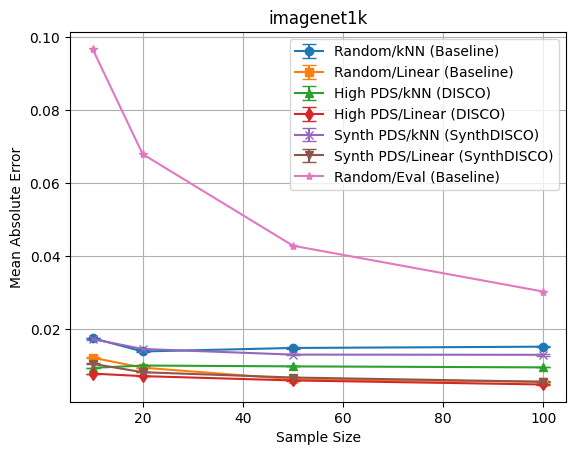

In [118]:
plot_average_model_performance_over_sample_size(model_confidences_tensor_dict={'Random/kNN (Baseline)': timm_model_confidence_for_val_samples_tensor,
                                                                               'Random/Linear (Baseline)': timm_model_confidence_for_val_samples_tensor,
                                                                               'High PDS/kNN (DISCO)': timm_model_confidence_for_val_samples_tensor[list(timm_top_disagreement_indices)],
                                                                               'High PDS/Linear (DISCO)': timm_model_confidence_for_val_samples_tensor[list(timm_top_disagreement_indices)],
                                                                               'Synth PDS/kNN (SynthDISCO)': timm_model_confidence_for_main_set_tensor,
                                                                               'Synth PDS/Linear (SynthDISCO)': timm_model_confidence_for_main_set_tensor
                                                                               },
                                                                               # 'cluster_representatives_l1': timm_model_confidence_for_val_samples_tensor[l1_dist_top_indices],
                                                                               # 'cluster_representatives_l2': timm_model_confidence_for_val_samples_tensor[l2_dist_top_indices]},
                                                model_catalog=timm_model_catalog,
                                                model_classes_for_evaluation={'Random/kNN (Baseline)': NNModel,
                                                                               'Random/Linear (Baseline)': MLPRegressor,
                                                                               'High PDS/kNN (DISCO)': NNModel,
                                                                               'High PDS/Linear (DISCO)': MLPRegressor,
                                                                               'Synth PDS/kNN (SynthDISCO)': NNModel,
                                                                               'Synth PDS/Linear (SynthDISCO)': MLPRegressor
                                                                               },
                                                                              # 'cluster_representatives_l1': SimpleNN,
                                                                              # 'cluster_representatives_l2': SimpleNN,},
                                                plot_for_datasets=['imagenet1k'],
                                                sample_sizes=[10,20,50,100],
                                                score_function='mae',
                                                sampling_strategy={'Random/kNN (Baseline)': 'random',
                                                                   'Random/Linear (Baseline)': 'random',
                                                                   'High PDS/kNN (DISCO)': 'first',
                                                                   'High PDS/Linear (DISCO)': 'first',
                                                                   'Synth PDS/kNN (SynthDISCO)': 'random',
                                                                   'Synth PDS/Linear (SynthDISCO)': 'random'
                                                                   },
                                                number_bootstraping_steps=5,
                                                k_fold_splits=4,
                                                x_log_scale=False,
                                                model_init_kwargs={
                                                    'hidden_channels': [128, 128, 1],
                                                },
                                                model_fitting_kwargs={
                                                    'n_epochs': 700,
                                                    'lr': 0.001,
                                                },
                                                verbose=False,
                                                add_baseline_for_sizes=[10,20,50,100],
                                                label_for_baseline='Random/Eval (Baseline)',
                                                gt_accuracies=timm_result_performances,
                                                train_model_index=timm_train_model_indices,
                                                val_model_index=timm_val_model_indices,
                                                save_path='/mnt/lustre/work/oh/owl813/repos/model-selection/figures/timm_complete_eval.png')

mean_rank_score_dict: {'imagenet1k': [0.7649399671090216, 0.765051135098807, 0.6456943045082633, 0.5691958791802197, 0.7410181790365121]}
mean_rank_score_dict: {'imagenet1k': [0.7828214500106115, 0.7007854190854819, 0.7814532332136964, 0.7561914336492003, 0.7472664017340102]}
mean_rank_score_dict: {'imagenet1k': [0.8324705059049633, 0.8058390608669308, 0.7479120098668679, 0.8408674075495614, 0.8314060169590645]}
mean_rank_score_dict: {'imagenet1k': [0.8635856296402336, 0.848630645005486, 0.8844975173228559, 0.7808353561657634, 0.8598807733542632]}
Epoch [10/700], Train-Loss: 0.2338, Val-Loss: 0.1923
Epoch [20/700], Train-Loss: 0.0404, Val-Loss: 0.0520
Epoch [30/700], Train-Loss: 0.0015, Val-Loss: 0.0040
Epoch [40/700], Train-Loss: 0.0063, Val-Loss: 0.0041
Epoch [50/700], Train-Loss: 0.0036, Val-Loss: 0.0032
Epoch [60/700], Train-Loss: 0.0008, Val-Loss: 0.0009
Epoch [70/700], Train-Loss: 0.0003, Val-Loss: 0.0003
Epoch [80/700], Train-Loss: 0.0003, Val-Loss: 0.0002
Epoch [90/700], Train-

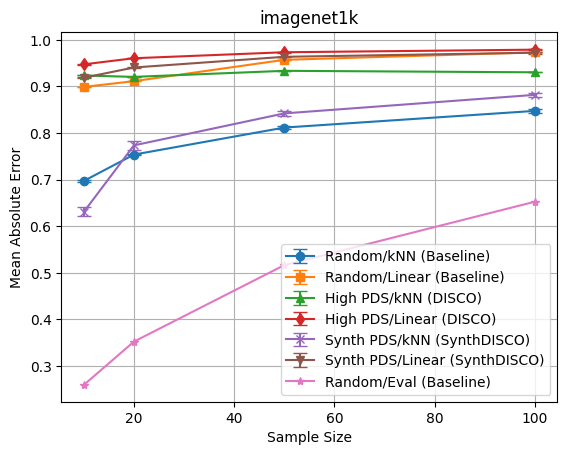

In [ ]:
plot_average_model_performance_over_sample_size(model_confidences_tensor_dict={'Random/kNN (Baseline)': timm_model_confidence_for_val_samples_tensor,
                                                                               'Random/Linear (Baseline)': timm_model_confidence_for_val_samples_tensor,
                                                                               'High PDS/kNN (DISCO)': timm_model_confidence_for_val_samples_tensor[list(timm_top_disagreement_indices)],
                                                                               'High PDS/Linear (DISCO)': timm_model_confidence_for_val_samples_tensor[list(timm_top_disagreement_indices)],
                                                                               'Synth PDS/kNN (SynthDISCO)': timm_model_confidence_for_main_set_tensor,
                                                                               'Synth PDS/Linear (SynthDISCO)': timm_model_confidence_for_main_set_tensor
                                                                               },
                                                                               # 'cluster_representatives_l1': timm_model_confidence_for_val_samples_tensor[l1_dist_top_indices],
                                                                               # 'cluster_representatives_l2': timm_model_confidence_for_val_samples_tensor[l2_dist_top_indices]},
                                                model_catalog=timm_model_catalog,
                                                score_function='rank',
                                                model_classes_for_evaluation={'Random/kNN (Baseline)': NNModel,
                                                                               'Random/Linear (Baseline)': MLPRegressor,
                                                                               'High PDS/kNN (DISCO)': NNModel,
                                                                               'High PDS/Linear (DISCO)': MLPRegressor,
                                                                               'Synth PDS/kNN (SynthDISCO)': NNModel,
                                                                               'Synth PDS/Linear (SynthDISCO)': MLPRegressor
                                                                               },
                                                                              # 'cluster_representatives_l1': SimpleNN,
                                                                              # 'cluster_representatives_l2': SimpleNN,},
                                                plot_for_datasets=['imagenet1k'],
                                                sample_sizes=[10,20,50,100],
                                                sampling_strategy={'Random/kNN (Baseline)': 'random',
                                                                   'Random/Linear (Baseline)': 'random',
                                                                   'High PDS/kNN (DISCO)': 'first',
                                                                   'High PDS/Linear (DISCO)': 'first',
                                                                   'Synth PDS/kNN (SynthDISCO)': 'random',
                                                                   'Synth PDS/Linear (SynthDISCO)': 'random'
                                                                   },
                                                number_bootstraping_steps=5,
                                                k_fold_splits=4,
                                                x_log_scale=False,
                                                model_init_kwargs={
                                                    'hidden_channels': [128, 128, 1],
                                                },
                                                model_fitting_kwargs={
                                                    'n_epochs': 700,
                                                    'lr': 0.001,
                                                },
                                                verbose=False,
                                                add_baseline_for_sizes=[10,20,50,100],
                                                label_for_baseline='Random/Eval (Baseline)',
                                                gt_accuracies=timm_result_performances,
                                                train_model_index=timm_train_model_indices,
                                                val_model_index=timm_val_model_indices,
                                                save_path='/mnt/lustre/work/oh/owl813/repos/model-selection/figures/timm_complete_eval_rank.png')

In [122]:
def get_predicted_and_gt_performance_lists(model_confidences_tensor: torch.tensor,
                                           model_catalog: Dict[str, Any],
                                           sample_size: int,
                                           k_fold_splits: int,
                                           evaluation_model_class: type,
                                           model_fitting_kwargs: Optional[Dict[str,Any]],
                                           verbose: bool=True,
                                           random_seed: int=1):
    gt_performances_initial_order = torch.tensor([model_info['results']['imagenet1k'] for model_info in model_catalog.values()], dtype=torch.float)
    kf = KFold(n_splits=k_fold_splits, shuffle=True, random_state=42)
    gt_preformances = []
    predicted_performances = []
    device=get_device(use_gpu=True)
    model_confidence_tensor_transposed = model_confidences_tensor.transpose(0, 1).to(device)
    random.seed = random_seed
    sample_indices = np.random.choice(model_confidence_tensor_transposed.shape[1], size=sample_size, replace=False)
    # indices = torch.tensor(np.random.choice(model_confidences_array.shape[1], size=sample_size, replace=replace))
    model_confidence_tensor_transposed_subsampled = model_confidence_tensor_transposed[:, sample_indices, :].reshape(model_confidence_tensor_transposed.shape[0], -1)
    shuffled_model_indices = torch.randperm(model_confidence_tensor_transposed_subsampled.size(0))
    shuffled_model_confidence_tensor_transposed_subsampled = model_confidence_tensor_transposed_subsampled[shuffled_model_indices]
    for train_index, val_index in kf.split(shuffled_model_confidence_tensor_transposed_subsampled):
        model_confidences_train, model_confidences_val = shuffled_model_confidence_tensor_transposed_subsampled[train_index], shuffled_model_confidence_tensor_transposed_subsampled[val_index]
        shuffled_performances = gt_performances_initial_order[shuffled_model_indices].to(device)
        perfomances_train, perfomances_val = shuffled_performances[train_index], shuffled_performances[val_index]
        pred_func = create_model_of_class(model_class=evaluation_model_class, input_size=model_confidences_train.shape[1]).to(device)
        if model_fitting_kwargs is not None:
            pred_func.fit(x=model_confidences_train, y=perfomances_train, x_val=model_confidences_val, y_val=perfomances_val, verbose=verbose, **model_fitting_kwargs)
        else:
            pred_func.fit(x=model_confidences_train, y=perfomances_train, x_val=model_confidences_val, y_val=perfomances_val, verbose=verbose)

        with torch.inference_mode():
            performances_val_pred = pred_func(x=model_confidences_val)
        gt_preformances += list(perfomances_val.cpu())
        predicted_performances += list(performances_val_pred.cpu())
    return predicted_performances, gt_preformances

In [124]:
path_to_save_folder = "/mnt/lustre/work/oh/owl813/repos/model-selection/checkpoints"
open_clip_model_confidence_for_main_set_tensor = torch.load(f=os.path.join(path_to_save_folder, "open_clip_model_confidences_for_main_set.tensor"))

/tmp/ipykernel_968094/1724587674.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  open_clip_model_confidence_for_main_set_tensor = torch.load(f=os.path.join(path_to_save_

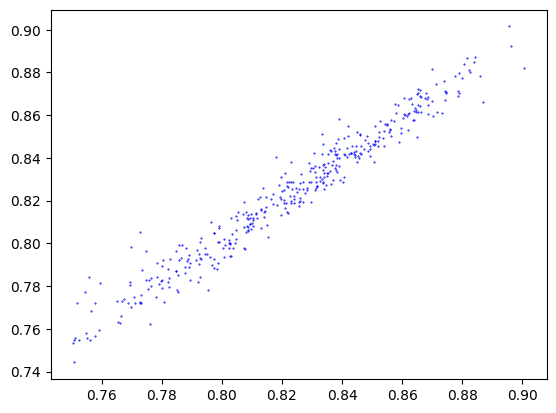

In [132]:
plt.scatter(x=[float(x) for x in gt_preformances_timm], y=[float(x) for x in predicted_performances_timm], s=0.2, label='Timm', c='blue')


scheduler_args:  {'gamma': 0.9616350847573034}
scheduler: <torch.optim.lr_scheduler.ExponentialLR object at 0x7f4b40550880>
Epoch [10/1000], Train-Loss: 0.1042, Val-Loss: 0.1037
Epoch [20/1000], Train-Loss: 0.0547, Val-Loss: 0.0514
Epoch [30/1000], Train-Loss: 0.0111, Val-Loss: 0.0137
Epoch [40/1000], Train-Loss: 0.0084, Val-Loss: 0.0136
Epoch [50/1000], Train-Loss: 0.0048, Val-Loss: 0.0074
Epoch [60/1000], Train-Loss: 0.0049, Val-Loss: 0.0052
Epoch [70/1000], Train-Loss: 0.0028, Val-Loss: 0.0053
Epoch [80/1000], Train-Loss: 0.0012, Val-Loss: 0.0057
Epoch [90/1000], Train-Loss: 0.0013, Val-Loss: 0.0057
Epoch [100/1000], Train-Loss: 0.0008, Val-Loss: 0.0050
Epoch [110/1000], Train-Loss: 0.0026, Val-Loss: 0.0074
Epoch [120/1000], Train-Loss: 0.0058, Val-Loss: 0.0079
Epoch [130/1000], Train-Loss: 0.0029, Val-Loss: 0.0051
Epoch [140/1000], Train-Loss: 0.0021, Val-Loss: 0.0062
Epoch [150/1000], Train-Loss: 0.0025, Val-Loss: 0.0054
Epoch [160/1000], Train-Loss: 0.0008, Val-Loss: 0.0066
Epoch

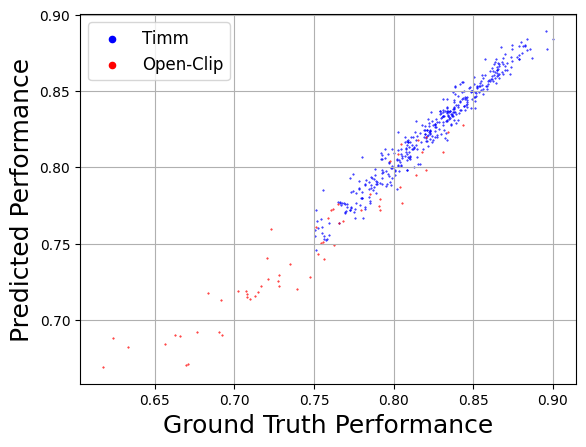

<Figure size 640x480 with 0 Axes>

In [133]:
# scatter plot for introduction

k_fold_splits = 4
sample_size = 100
model_fitting_kwargs = {
    'start_lr': 0.005,
    'epochs': 1000,
    'scheduler_class': torch.optim.lr_scheduler.ExponentialLR,
    'scheduler_args': {'gamma': float(np.power(1e-4/0.005, 1/100))},
    }
evaluation_model_class = SimpleNN

predicted_performances_timm, gt_preformances_timm = get_predicted_and_gt_performance_lists(model_confidences_tensor=timm_model_confidence_for_main_set_tensor,
                                                                                           model_catalog=timm_model_catalog,
                                                                                           sample_size=sample_size,
                                                                                           k_fold_splits=k_fold_splits,
                                                                                           evaluation_model_class=SimpleNN,
                                                                                           model_fitting_kwargs=model_fitting_kwargs)

predicted_performances_open_clip, gt_preformances_open_clip = get_predicted_and_gt_performance_lists(model_confidences_tensor=open_clip_model_confidence_for_main_set_tensor,
                                                                                           model_catalog=open_clip_model_catalog,
                                                                                           sample_size=sample_size,
                                                                                           k_fold_splits=k_fold_splits,
                                                                                           evaluation_model_class=SimpleNN,
                                                                                           model_fitting_kwargs=model_fitting_kwargs)

fig, ax = plt.subplots()
ax.scatter(x=[float(x) for x in gt_preformances_timm], y=[float(x) for x in predicted_performances_timm], s=0.2, label='Timm', c='blue')
ax.scatter(x=[float(x) for x in gt_preformances_open_clip], y=[float(x) for x in predicted_performances_open_clip], s=0.2, label='Open-Clip', c='red')
ax.set_xlabel('Ground Truth Performance', fontsize=18)
ax.set_ylabel('Predicted Performance', fontsize=18)

ax.legend(scatterpoints=1, markerscale=10, fontsize='large')
ax.grid(True)
plt.show()
plt.savefig('/mnt/lustre/work/oh/owl813/repos/model-selection/figures/pred_perf_vs_get_perf.png')

# Val Sample Selection - ImageNet (Timm)

In [48]:
timm_result_performances = []
for model_info in timm_model_catalog.values():
    timm_result_performances.append(model_info['results']['imagenet1k'])

In [49]:
baseline_mae(100, timm_result_performances)

0.030274022825760017

In [50]:
baseline_empirical_rank_score(100, timm_result_performances, 1000)

0.6528228970272456

In [72]:
all_datasets = {'imagenet1k'}

In [76]:
mae, rank = get_average_absolute_error_with_model_class(model_confidences_tensor=timm_model_confidence_for_val_samples_tensor,
                                            model_catalog=timm_model_catalog,
                                            evaluation_model_class=NNModel,
                                            number_bootstraping_steps=10,
                                            sample_size=100,
                                            sampling_strategy='random',
                                            for_datasets=all_datasets,
                                            k_fold_splits=2,
                                            train_model_index=timm_train_model_indices,
                                            val_model_index=timm_val_model_indices,
                                            verbose=False,
                                            calculate_rank_score=True)

print('mae: ', sum(mae['imagenet1k'])/len(mae['imagenet1k']), '; rank: ', sum([x.correlation for x in rank['imagenet1k']])/len(rank['imagenet1k']))

mae:  tensor(0.0141) ; rank:  0.8724969633821443


In [75]:
mae, rank = get_average_absolute_error_with_model_class(model_confidences_tensor=timm_model_confidence_for_val_samples_tensor[list(timm_top_disagreement_indices)],
                                            model_catalog=timm_model_catalog,
                                            evaluation_model_class=NNModel,
                                            number_bootstraping_steps=1,
                                            sample_size=100,
                                            sampling_strategy='first',
                                            for_datasets=all_datasets,
                                            k_fold_splits=2,
                                            train_model_index=timm_train_model_indices,
                                            val_model_index=timm_val_model_indices,
                                            verbose=False,
                                            calculate_rank_score=True)

print('mae: ', sum(mae['imagenet1k'])/len(mae['imagenet1k']), '; rank: ', sum([x.correlation for x in rank['imagenet1k']])/len(rank['imagenet1k']))

mae:  tensor(0.0095) ; rank:  0.930287519283355


In [74]:
mae, rank = get_average_absolute_error_with_model_class(model_confidences_tensor=timm_model_confidence_for_val_samples_tensor,
                                            model_catalog=timm_model_catalog,
                                            evaluation_model_class=MLPRegressor,
                                            number_bootstraping_steps=10,
                                            sample_size=100,
                                            sampling_strategy='random',
                                            for_datasets=all_datasets,
                                            k_fold_splits=2,
                                            model_init_kwargs={
                                                'hidden_channels': [128, 128, 1],
                                            },
                                            model_fitting_kwargs={
                                                'n_epochs': 700,
                                                'lr': 0.001,
                                            },
                                            train_model_index=timm_train_model_indices,
                                            val_model_index=timm_val_model_indices,
                                            verbose=False,
                                            calculate_rank_score=True)

print('mae: ', sum(mae['imagenet1k'])/len(mae['imagenet1k']), '; rank: ', sum([x.correlation for x in rank['imagenet1k']])/len(rank['imagenet1k']))

Epoch [10/700], Train-Loss: 0.0626, Val-Loss: 0.0964
Epoch [20/700], Train-Loss: 0.0205, Val-Loss: 0.0264
Epoch [30/700], Train-Loss: 0.0027, Val-Loss: 0.0051
Epoch [40/700], Train-Loss: 0.0010, Val-Loss: 0.0021
Epoch [50/700], Train-Loss: 0.0003, Val-Loss: 0.0006
Epoch [60/700], Train-Loss: 0.0002, Val-Loss: 0.0004
Epoch [70/700], Train-Loss: 0.0002, Val-Loss: 0.0002
Epoch [80/700], Train-Loss: 0.0001, Val-Loss: 0.0001
Epoch [90/700], Train-Loss: 0.0001, Val-Loss: 0.0001
Epoch [100/700], Train-Loss: 0.0001, Val-Loss: 0.0000
Epoch [110/700], Train-Loss: 0.0000, Val-Loss: 0.0000
Epoch [120/700], Train-Loss: 0.0000, Val-Loss: 0.0000
Epoch [130/700], Train-Loss: 0.0000, Val-Loss: 0.0000
Epoch [140/700], Train-Loss: 0.0000, Val-Loss: 0.0000
Epoch [150/700], Train-Loss: 0.0000, Val-Loss: 0.0000
Epoch [160/700], Train-Loss: 0.0000, Val-Loss: 0.0000
Epoch [170/700], Train-Loss: 0.0000, Val-Loss: 0.0000
Epoch [180/700], Train-Loss: 0.0000, Val-Loss: 0.0000
Epoch [190/700], Train-Loss: 0.0000, 

In [73]:
mae, rank = get_average_absolute_error_with_model_class(model_confidences_tensor=timm_model_confidence_for_val_samples_tensor[list(timm_top_disagreement_indices)],
                                            model_catalog=timm_model_catalog,
                                            evaluation_model_class=MLPRegressor,
                                            number_bootstraping_steps=10,
                                            sample_size=100,
                                            sampling_strategy='first',
                                            for_datasets=all_datasets,
                                            k_fold_splits=2,
                                            model_init_kwargs={
                                                'hidden_channels': [128, 128, 1],
                                            },
                                            model_fitting_kwargs={
                                                'n_epochs': 700,
                                                'lr': 0.001,
                                            },
                                            train_model_index=timm_train_model_indices,
                                            val_model_index=timm_val_model_indices,
                                            verbose=False,
                                            calculate_rank_score=True)

print('mae: ', sum(mae['imagenet1k'])/len(mae['imagenet1k']), '; rank: ', sum([x.correlation for x in rank['imagenet1k']])/len(rank['imagenet1k']))

Epoch [10/700], Train-Loss: 0.0747, Val-Loss: 0.0356
Epoch [20/700], Train-Loss: 0.0192, Val-Loss: 0.0118
Epoch [30/700], Train-Loss: 0.0054, Val-Loss: 0.0019
Epoch [40/700], Train-Loss: 0.0015, Val-Loss: 0.0006
Epoch [50/700], Train-Loss: 0.0001, Val-Loss: 0.0001
Epoch [60/700], Train-Loss: 0.0000, Val-Loss: 0.0001
Epoch [70/700], Train-Loss: 0.0001, Val-Loss: 0.0002
Epoch [80/700], Train-Loss: 0.0001, Val-Loss: 0.0001
Epoch [90/700], Train-Loss: 0.0000, Val-Loss: 0.0000
Epoch [100/700], Train-Loss: 0.0000, Val-Loss: 0.0000
Epoch [110/700], Train-Loss: 0.0000, Val-Loss: 0.0000
Epoch [120/700], Train-Loss: 0.0000, Val-Loss: 0.0000
Epoch [130/700], Train-Loss: 0.0000, Val-Loss: 0.0000
Epoch [140/700], Train-Loss: 0.0000, Val-Loss: 0.0000
Epoch [150/700], Train-Loss: 0.0000, Val-Loss: 0.0000
Epoch [160/700], Train-Loss: 0.0000, Val-Loss: 0.0000
Epoch [170/700], Train-Loss: 0.0000, Val-Loss: 0.0000
Epoch [180/700], Train-Loss: 0.0000, Val-Loss: 0.0000
Epoch [190/700], Train-Loss: 0.0000, 

# Val Sample Selection - Cifar (open-clip)

In [64]:
open_clip_result_performances = []
for model_info in open_clip_model_catalog.values():
    open_clip_result_performances.append(model_info['results']['CIFAR-100'])

In [65]:
baseline_mae(100, open_clip_result_performances)

0.031948958143207605

In [66]:
baseline_empirical_rank_score(100, timm_result_performances, 1000)

0.6522270644105292

In [78]:
all_datasets = {'CIFAR-100'}

In [81]:
mae, rank = get_average_absolute_error_with_model_class(model_confidences_tensor=open_clip_model_confidence_for_val_samples_tensor,
                                            model_catalog=open_clip_model_catalog,
                                            evaluation_model_class=NNModel,
                                            number_bootstraping_steps=10,
                                            sample_size=100,
                                            sampling_strategy='random',
                                            for_datasets=all_datasets,
                                            k_fold_splits=2,
                                            train_model_index=open_clip_train_model_indices,
                                            val_model_index=open_clip_val_model_indices,
                                            verbose=False,
                                            calculate_rank_score=True)

print('mae: ', sum(mae['CIFAR-100'])/len(mae['CIFAR-100']), '; rank: ', sum([x.correlation for x in rank['CIFAR-100']])/len(rank['CIFAR-100']))

mae:  tensor(0.0376) ; rank:  0.8607151511252298


In [82]:
mae, rank = get_average_absolute_error_with_model_class(model_confidences_tensor=open_clip_model_confidence_for_val_samples_tensor[list(open_clip_top_disagreement_indices)],
                                            model_catalog=open_clip_model_catalog,
                                            evaluation_model_class=NNModel,
                                            number_bootstraping_steps=1,
                                            sample_size=100,
                                            sampling_strategy='first',
                                            for_datasets=all_datasets,
                                            k_fold_splits=2,
                                            train_model_index=open_clip_train_model_indices,
                                            val_model_index=open_clip_val_model_indices,
                                            verbose=False,
                                            calculate_rank_score=True)

print('mae: ', sum(mae['CIFAR-100'])/len(mae['CIFAR-100']), '; rank: ', sum([x.correlation for x in rank['CIFAR-100']])/len(rank['CIFAR-100']))

mae:  tensor(0.0318) ; rank:  0.8318439070608654


In [83]:
mae, rank = get_average_absolute_error_with_model_class(model_confidences_tensor=open_clip_model_confidence_for_val_samples_tensor,
                                            model_catalog=open_clip_model_catalog,
                                            evaluation_model_class=MLPRegressor,
                                            number_bootstraping_steps=10,
                                            sample_size=100,
                                            sampling_strategy='random',
                                            for_datasets=all_datasets,
                                            k_fold_splits=2,
                                            model_init_kwargs={
                                                'hidden_channels': [128, 128, 1],
                                            },
                                            model_fitting_kwargs={
                                                'n_epochs': 700,
                                                'lr': 0.001,
                                            },
                                            train_model_index=open_clip_train_model_indices,
                                            val_model_index=open_clip_val_model_indices,
                                            verbose=False,
                                            calculate_rank_score=True)

print('mae: ', sum(mae['CIFAR-100'])/len(mae['CIFAR-100']), '; rank: ', sum([x.correlation for x in rank['CIFAR-100']])/len(rank['CIFAR-100']))

Epoch [10/700], Train-Loss: 0.1203, Val-Loss: 0.1121
Epoch [20/700], Train-Loss: 0.0305, Val-Loss: 0.0192
Epoch [30/700], Train-Loss: 0.0100, Val-Loss: 0.0087
Epoch [40/700], Train-Loss: 0.0032, Val-Loss: 0.0023
Epoch [50/700], Train-Loss: 0.0010, Val-Loss: 0.0012
Epoch [60/700], Train-Loss: 0.0003, Val-Loss: 0.0007
Epoch [70/700], Train-Loss: 0.0001, Val-Loss: 0.0008
Epoch [80/700], Train-Loss: 0.0000, Val-Loss: 0.0009
Epoch [90/700], Train-Loss: 0.0000, Val-Loss: 0.0007
Epoch [100/700], Train-Loss: 0.0000, Val-Loss: 0.0007
Epoch [110/700], Train-Loss: 0.0000, Val-Loss: 0.0007
Epoch [120/700], Train-Loss: 0.0000, Val-Loss: 0.0007
Epoch [130/700], Train-Loss: 0.0000, Val-Loss: 0.0007
Epoch [140/700], Train-Loss: 0.0000, Val-Loss: 0.0007
Epoch [150/700], Train-Loss: 0.0000, Val-Loss: 0.0007
Epoch [160/700], Train-Loss: 0.0000, Val-Loss: 0.0007
Epoch [170/700], Train-Loss: 0.0000, Val-Loss: 0.0007
Epoch [180/700], Train-Loss: 0.0000, Val-Loss: 0.0007
Epoch [190/700], Train-Loss: 0.0000, 

In [87]:
mae, rank = get_average_absolute_error_with_model_class(model_confidences_tensor=open_clip_model_confidence_for_val_samples_tensor[list(open_clip_top_disagreement_indices)],
                                            model_catalog=open_clip_model_catalog,
                                            evaluation_model_class=MLPRegressor,
                                            number_bootstraping_steps=10,
                                            sample_size=100,
                                            sampling_strategy='first',
                                            for_datasets=all_datasets,
                                            k_fold_splits=2,
                                            model_init_kwargs={
                                                'hidden_channels': [128, 128, 1],
                                            },
                                            model_fitting_kwargs={
                                                'n_epochs': 700,
                                                'lr': 0.001,
                                            },
                                            train_model_index=open_clip_train_model_indices,
                                            val_model_index=open_clip_val_model_indices,
                                            verbose=False,
                                            calculate_rank_score=True)

print('mae: ', sum(mae['CIFAR-100'])/len(mae['CIFAR-100']), '; rank: ', sum([x.correlation for x in rank['CIFAR-100']])/len(rank['CIFAR-100']))

Epoch [10/700], Train-Loss: 0.0994, Val-Loss: 0.0643
Epoch [20/700], Train-Loss: 0.0260, Val-Loss: 0.0140
Epoch [30/700], Train-Loss: 0.0074, Val-Loss: 0.0056
Epoch [40/700], Train-Loss: 0.0020, Val-Loss: 0.0023
Epoch [50/700], Train-Loss: 0.0002, Val-Loss: 0.0025
Epoch [60/700], Train-Loss: 0.0000, Val-Loss: 0.0029
Epoch [70/700], Train-Loss: 0.0001, Val-Loss: 0.0022
Epoch [80/700], Train-Loss: 0.0001, Val-Loss: 0.0026
Epoch [90/700], Train-Loss: 0.0000, Val-Loss: 0.0024
Epoch [100/700], Train-Loss: 0.0000, Val-Loss: 0.0023
Epoch [110/700], Train-Loss: 0.0000, Val-Loss: 0.0024
Epoch [120/700], Train-Loss: 0.0000, Val-Loss: 0.0024
Epoch [130/700], Train-Loss: 0.0000, Val-Loss: 0.0024
Epoch [140/700], Train-Loss: 0.0000, Val-Loss: 0.0024
Epoch [150/700], Train-Loss: 0.0000, Val-Loss: 0.0024
Epoch [160/700], Train-Loss: 0.0000, Val-Loss: 0.0024
Epoch [170/700], Train-Loss: 0.0000, Val-Loss: 0.0024
Epoch [180/700], Train-Loss: 0.0000, Val-Loss: 0.0024
Epoch [190/700], Train-Loss: 0.0000, 

# Synthetic Samples - Timm

In [88]:
path_to_save_folder = "/mnt/lustre/work/oh/owl813/repos/model-selection/checkpoints"
timm_model_confidence_for_main_set_tensor = torch.load(f=os.path.join(path_to_save_folder, "timm_model_confidences_for_main_set.tensor"))

/tmp/ipykernel_968094/1717516195.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  timm_model_confidence_for_main_set_tensor = torch.load(f=os.path.join(path_to_save_folde

In [89]:
disagreement_scores = get_disagreement_scores(timm_model_confidence_for_main_set_tensor.transpose(0,1), n_guiding_models=100)
top_disagreement_indices_main_set = disagreement_scores.argsort()[::-1][:100]

In [94]:
all_datasets = {'imagenet1k'}

In [98]:
mae, rank = get_average_absolute_error_with_model_class(model_confidences_tensor=timm_model_confidence_for_main_set_tensor,
                                            model_catalog=timm_model_catalog,
                                            evaluation_model_class=NNModel,
                                            number_bootstraping_steps=10,
                                            sample_size=100,
                                            sampling_strategy='random',
                                            for_datasets=all_datasets,
                                            k_fold_splits=2,
                                            train_model_index=timm_train_model_indices,
                                            val_model_index=timm_val_model_indices,
                                            verbose=False,
                                            calculate_rank_score=True)

print('mae: ', sum(mae['imagenet1k'])/len(mae['imagenet1k']), '; rank: ', sum([x.correlation for x in rank['imagenet1k']])/len(rank['imagenet1k']))

mae:  tensor(0.0131) ; rank:  0.8744069686961529


In [97]:
mae, rank = get_average_absolute_error_with_model_class(model_confidences_tensor=timm_model_confidence_for_main_set_tensor,
                                            model_catalog=timm_model_catalog,
                                            evaluation_model_class=MLPRegressor,
                                            number_bootstraping_steps=10,
                                            sample_size=100,
                                            sampling_strategy='random',
                                            for_datasets=all_datasets,
                                            k_fold_splits=2,
                                            model_init_kwargs={
                                                'hidden_channels': [128, 128, 1],
                                            },
                                            model_fitting_kwargs={
                                                'n_epochs': 700,
                                                'lr': 0.001,
                                            },
                                            train_model_index=timm_train_model_indices,
                                            val_model_index=timm_val_model_indices,
                                            verbose=False,
                                            calculate_rank_score=True)

print('mae: ', sum(mae['imagenet1k'])/len(mae['imagenet1k']), '; rank: ', sum([x.correlation for x in rank['imagenet1k']])/len(rank['imagenet1k']))

Epoch [10/700], Train-Loss: 0.0555, Val-Loss: 0.0210
Epoch [20/700], Train-Loss: 0.0133, Val-Loss: 0.0066
Epoch [30/700], Train-Loss: 0.0024, Val-Loss: 0.0005
Epoch [40/700], Train-Loss: 0.0005, Val-Loss: 0.0001
Epoch [50/700], Train-Loss: 0.0001, Val-Loss: 0.0003
Epoch [60/700], Train-Loss: 0.0002, Val-Loss: 0.0003
Epoch [70/700], Train-Loss: 0.0002, Val-Loss: 0.0002
Epoch [80/700], Train-Loss: 0.0001, Val-Loss: 0.0000
Epoch [90/700], Train-Loss: 0.0000, Val-Loss: 0.0000
Epoch [100/700], Train-Loss: 0.0000, Val-Loss: 0.0001
Epoch [110/700], Train-Loss: 0.0000, Val-Loss: 0.0000
Epoch [120/700], Train-Loss: 0.0000, Val-Loss: 0.0000
Epoch [130/700], Train-Loss: 0.0000, Val-Loss: 0.0000
Epoch [140/700], Train-Loss: 0.0000, Val-Loss: 0.0000
Epoch [150/700], Train-Loss: 0.0000, Val-Loss: 0.0000
Epoch [160/700], Train-Loss: 0.0000, Val-Loss: 0.0000
Epoch [170/700], Train-Loss: 0.0000, Val-Loss: 0.0000
Epoch [180/700], Train-Loss: 0.0000, Val-Loss: 0.0000
Epoch [190/700], Train-Loss: 0.0000, 

# Rest

In [ ]:
all_datasets = {'imagenet1k'}

get_average_absolute_error_with_model_class(model_confidences_tensor=timm_model_confidence_for_val_samples_tensor[list(timm_top_disagreement_indices)],
                                            model_catalog=timm_model_catalog,
                                            evaluation_model_class=SimpleNN,
                                            number_bootstraping_steps=1,
                                            sample_size=100,
                                            for_datasets=all_datasets,
                                            k_fold_splits=2,
                                            model_fitting_kwargs={
                                                    'start_lr': 0.005,
                                                    'epochs': 1000,
                                                    'scheduler_class': torch.optim.lr_scheduler.ExponentialLR,
                                                    'scheduler_args': {'gamma': float(np.power(1e-4/0.005, 1/100))},
                                                },
                                            pca_comp=-100,
                                            train_model_index=timm_train_model_indices,
                                            val_model_index=timm_val_model_indices,
                                            verbose=True)

/home/oh/owl813/.conda/envs/model-selection/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


perfomances_train tensor([0.8786, 0.8790, 0.8816, 0.8580, 0.8541, 0.8787, 0.8664, 0.8195, 0.8596,
        0.8549, 0.8621, 0.8703, 0.8629, 0.8555, 0.8653, 0.8800, 0.8660, 0.8824,
        0.8558, 0.8493, 0.8510, 0.8624, 0.8838, 0.8008, 0.7709, 0.7929, 0.7730,
        0.7549, 0.8648, 0.8155, 0.8589, 0.7868, 0.7932, 0.7688, 0.7809, 0.8165,
        0.7565, 0.8383, 0.8536, 0.8325, 0.8575, 0.8131, 0.8241, 0.8493, 0.7667,
        0.7511, 0.8024, 0.8777, 0.8746, 0.7732, 0.7505, 0.8610, 0.7983, 0.7926,
        0.7696, 0.7727, 0.8685, 0.7878, 0.7661, 0.8087, 0.7791, 0.7551, 0.7579,
        0.8113, 0.8453, 0.8564, 0.8179, 0.8074, 0.8511, 0.8421, 0.8024, 0.8222,
        0.7545, 0.7884, 0.8259, 0.8141, 0.8860, 0.8217, 0.8335, 0.8682, 0.8841,
        0.7596, 0.8148, 0.8407, 0.8524, 0.8231, 0.8276, 0.8248, 0.8649, 0.7975,
        0.8336, 0.8658, 0.8239, 0.8352, 0.8239, 0.8170, 0.8460, 0.8740, 0.8464,
        0.8200, 0.8448, 0.8654, 0.8055, 0.8206, 0.8298, 0.8303, 0.8335, 0.8664,
        0.8270, 0.7849

{'imagenet1k': [tensor(0.1739)]}

In [25]:
all_datasets = {'imagenet1k'}

get_average_absolute_error_with_model_class(model_confidences_tensor=timm_model_confidence_for_val_samples_tensor[list(top_disagreement_indices)],
                                            model_catalog=timm_model_catalog,
                                            evaluation_model_class=SimpleNN,
                                            number_bootstraping_steps=10,
                                            sample_size=100,
                                            for_datasets=all_datasets,
                                            k_fold_splits=2,
                                            model_fitting_kwargs={
                                                    'start_lr': 0.005,
                                                    'epochs': 1000,
                                                    'scheduler_class': torch.optim.lr_scheduler.ExponentialLR,
                                                    'scheduler_args': {'gamma': float(np.power(1e-4/0.005, 1/100))},
                                                },
                                            train_model_index=timm_train_model_indices,
                                            val_model_index=timm_val_model_indices,
                                            verbose=False)

scheduler_args:  {'gamma': 0.9616350847573034}
scheduler: <torch.optim.lr_scheduler.ExponentialLR object at 0x7f1b3e427550>


scheduler_args:  {'gamma': 0.9616350847573034}
scheduler: <torch.optim.lr_scheduler.ExponentialLR object at 0x7f1b3e425f30>
scheduler_args:  {'gamma': 0.9616350847573034}
scheduler: <torch.optim.lr_scheduler.ExponentialLR object at 0x7f1b3e426830>
scheduler_args:  {'gamma': 0.9616350847573034}
scheduler: <torch.optim.lr_scheduler.ExponentialLR object at 0x7f1b3e426f50>
scheduler_args:  {'gamma': 0.9616350847573034}
scheduler: <torch.optim.lr_scheduler.ExponentialLR object at 0x7f1b3e425de0>
scheduler_args:  {'gamma': 0.9616350847573034}
scheduler: <torch.optim.lr_scheduler.ExponentialLR object at 0x7f1b3e427550>
scheduler_args:  {'gamma': 0.9616350847573034}
scheduler: <torch.optim.lr_scheduler.ExponentialLR object at 0x7f1b3e425f30>
scheduler_args:  {'gamma': 0.9616350847573034}
scheduler: <torch.optim.lr_scheduler.ExponentialLR object at 0x7f1b3e426830>
scheduler_args:  {'gamma': 0.9616350847573034}
scheduler: <torch.optim.lr_scheduler.ExponentialLR object at 0x7f1b3e426f50>
schedule

{'imagenet1k': [tensor(0.0051),
  tensor(0.0050),
  tensor(0.0050),
  tensor(0.0050),
  tensor(0.0050),
  tensor(0.0050),
  tensor(0.0049),
  tensor(0.0050),
  tensor(0.0049),
  tensor(0.0050)]}

In [26]:
all_datasets = {'imagenet1k'}

get_average_absolute_error_with_model_class(model_confidences_tensor=timm_model_confidence_for_val_samples_tensor[list(top_disagreement_indices)],
                                            model_catalog=timm_model_catalog,
                                            evaluation_model_class=MLPRegressor,
                                            number_bootstraping_steps=10,
                                            sample_size=100,
                                            for_datasets=all_datasets,
                                            k_fold_splits=2,
                                            model_init_kwargs={
                                                'hidden_channels': [128, 128, 1],
                                            },
                                            model_fitting_kwargs={
                                                'n_epochs': 700,
                                                'lr': 0.001,
                                            },
                                            train_model_index=timm_train_model_indices,
                                            val_model_index=timm_val_model_indices,
                                            verbose=False)

Epoch [10/700], Train-Loss: 0.0957, Val-Loss: 0.1210
Epoch [20/700], Train-Loss: 0.0311, Val-Loss: 0.0353
Epoch [30/700], Train-Loss: 0.0060, Val-Loss: 0.0088
Epoch [40/700], Train-Loss: 0.0021, Val-Loss: 0.0036
Epoch [50/700], Train-Loss: 0.0007, Val-Loss: 0.0011
Epoch [60/700], Train-Loss: 0.0004, Val-Loss: 0.0007
Epoch [70/700], Train-Loss: 0.0002, Val-Loss: 0.0002
Epoch [80/700], Train-Loss: 0.0001, Val-Loss: 0.0001
Epoch [90/700], Train-Loss: 0.0000, Val-Loss: 0.0001
Epoch [100/700], Train-Loss: 0.0000, Val-Loss: 0.0000
Epoch [110/700], Train-Loss: 0.0000, Val-Loss: 0.0000
Epoch [120/700], Train-Loss: 0.0000, Val-Loss: 0.0000
Epoch [130/700], Train-Loss: 0.0000, Val-Loss: 0.0000
Epoch [140/700], Train-Loss: 0.0000, Val-Loss: 0.0000
Epoch [150/700], Train-Loss: 0.0000, Val-Loss: 0.0000
Epoch [160/700], Train-Loss: 0.0000, Val-Loss: 0.0000
Epoch [170/700], Train-Loss: 0.0000, Val-Loss: 0.0000
Epoch [180/700], Train-Loss: 0.0000, Val-Loss: 0.0000
Epoch [190/700], Train-Loss: 0.0000, 

{'imagenet1k': [tensor(0.0052),
  tensor(0.0050),
  tensor(0.0051),
  tensor(0.0051),
  tensor(0.0051),
  tensor(0.0051),
  tensor(0.0049),
  tensor(0.0051),
  tensor(0.0051),
  tensor(0.0050)]}

In [ ]:
all_datasets = {'imagenet1k'}

get_average_absolute_error_with_model_class(model_confidences_tensor=timm_model_confidence_for_val_samples_tensor[list(top_disagreement_indices)],
                                            model_catalog=timm_model_catalog,
                                            evaluation_model_class=MLPRegressor,
                                            number_bootstraping_steps=10,
                                            sample_size=100,
                                            for_datasets=all_datasets,
                                            k_fold_splits=2,
                                            model_init_kwargs={
                                                'hidden_channels': [128, 128, 1],
                                            },
                                            model_fitting_kwargs={
                                                'n_epochs': 700,
                                                'lr': 0.001,
                                            },
                                            train_model_index=train_model_indices,
                                            val_model_index=val_model_indices,
                                            verbose=False)

perfomances_train tensor([0.8786, 0.8790, 0.8816, 0.8580, 0.8541, 0.8787, 0.8664, 0.8195, 0.8596,
        0.8549, 0.8621, 0.8703, 0.8629, 0.8555, 0.8653, 0.8800, 0.8660, 0.8824,
        0.8558, 0.8493, 0.8510, 0.8624, 0.8838, 0.8008, 0.7709, 0.7929, 0.7730,
        0.7549, 0.8648, 0.8155, 0.8589, 0.7868, 0.7932, 0.7688, 0.7809, 0.8165,
        0.7565, 0.8383, 0.8536, 0.8325, 0.8575, 0.8131, 0.8241, 0.8493, 0.7667,
        0.7511, 0.8024, 0.8777, 0.8746, 0.7732, 0.7505, 0.8610, 0.7983, 0.7926,
        0.7696, 0.7727, 0.8685, 0.7878, 0.7661, 0.8087, 0.7791, 0.7551, 0.7579,
        0.8113, 0.8453, 0.8564, 0.8179, 0.8074, 0.8511, 0.8421, 0.8024, 0.8222,
        0.7545, 0.7884, 0.8259, 0.8141, 0.8860, 0.8217, 0.8335, 0.8682, 0.8841,
        0.7596, 0.8148, 0.8407, 0.8524, 0.8231, 0.8276, 0.8248, 0.8649, 0.7975,
        0.8336, 0.8658, 0.8239, 0.8352, 0.8239, 0.8170, 0.8460, 0.8740, 0.8464,
        0.8200, 0.8448, 0.8654, 0.8055, 0.8206, 0.8298, 0.8303, 0.8335, 0.8664,
        0.8270, 0.7849

{'imagenet1k': [tensor(0.0045),
  tensor(0.0046),
  tensor(0.0045),
  tensor(0.0046),
  tensor(0.0045),
  tensor(0.0046),
  tensor(0.0046),
  tensor(0.0045),
  tensor(0.0046),
  tensor(0.0045)]}

/tmp/ipykernel_4024989/1717516195.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  timm_model_confidence_for_main_set_tensor = torch.load(f=os.path.join(path_to_save_fold

NameError: name 'get_disagreement_scores' is not defined

perfomances_train tensor([0.8786, 0.8790, 0.8816, 0.8580, 0.8541, 0.8787, 0.8664, 0.8195, 0.8596,
        0.8549, 0.8621, 0.8703, 0.8629, 0.8555, 0.8653, 0.8800, 0.8660, 0.8824,
        0.8558, 0.8493, 0.8510, 0.8624, 0.8838, 0.8008, 0.7709, 0.7929, 0.7730,
        0.7549, 0.8648, 0.8155, 0.8589, 0.7868, 0.7932, 0.7688, 0.7809, 0.8165,
        0.7565, 0.8383, 0.8536, 0.8325, 0.8575, 0.8131, 0.8241, 0.8493, 0.7667,
        0.7511, 0.8024, 0.8777, 0.8746, 0.7732, 0.7505, 0.8610, 0.7983, 0.7926,
        0.7696, 0.7727, 0.8685, 0.7878, 0.7661, 0.8087, 0.7791, 0.7551, 0.7579,
        0.8113, 0.8453, 0.8564, 0.8179, 0.8074, 0.8511, 0.8421, 0.8024, 0.8222,
        0.7545, 0.7884, 0.8259, 0.8141, 0.8860, 0.8217, 0.8335, 0.8682, 0.8841,
        0.7596, 0.8148, 0.8407, 0.8524, 0.8231, 0.8276, 0.8248, 0.8649, 0.7975,
        0.8336, 0.8658, 0.8239, 0.8352, 0.8239, 0.8170, 0.8460, 0.8740, 0.8464,
        0.8200, 0.8448, 0.8654, 0.8055, 0.8206, 0.8298, 0.8303, 0.8335, 0.8664,
        0.8270, 0.7849

{'imagenet1k': [tensor(0.0055),
  tensor(0.0054),
  tensor(0.0056),
  tensor(0.0056),
  tensor(0.0056),
  tensor(0.0057),
  tensor(0.0056),
  tensor(0.0056),
  tensor(0.0056),
  tensor(0.0056)]}